In [3]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",100)

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from datetime import datetime as dt

from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import encode_batch_weighted, onehot_batch_decode, onehot_decode, INT_TO_CHAR, get_tensor_dataset, encode_batch, BL62_VALUES, BL62FREQ_VALUES, get_array_dataset
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from src.metrics import get_metrics, plot_roc_auc_fold, get_mean_roc_curve, get_pred_df, get_mean_pr_curve
from src.train_eval import train_loop, nested_kcv_train_nn, evaluate_trained_models_nn
from src.train_eval import kcv_tune_sklearn, evaluate_trained_models_sklearn, nested_kcv_train_sklearn
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump

if torch.cuda.is_available():    
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device = "cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'
    
from src.partition_tools import pipeline_stratified_kfold

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
mpl.rcParams['figure.dpi'] = 180

RESDIR='../output/220906_analysis/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3070 Laptop GPU


In [84]:
# Reload results
encoding_weight_results = pkl_load('../output/bootstrapping/encoding_weighting.pkl')
features_results = pkl_load('../output/bootstrapping/features_results.pkl')
trainset_models_results = pkl_load('../output/bootstrapping/trainset_models.pkl')

In [4]:
from scipy.stats import ttest_ind, mannwhitneyu, wilcoxon

# init

## reloading datasets

In [8]:
cedar = pd.read_csv('../data/partitioned_traindata_redo/cedar_10fold.csv')
cedar['trainset']='cedar'

cedar_viral_old = pd.read_csv('../data/partitioned_traindata/cedar_viral_10fold.csv')
cedar_viral_old['trainset']='cedar_virus_old'

cedar_viral_more = pd.read_csv('../data/partitioned_traindata_redo/new_cedar_viral_5fold.csv')
cedar_viral_more['trainset']='cedar_virus_new'
# USE PRIME FOR BASELINE VERIFICATION, PRIME_FOLD FOR ACTUAL TRAINING
prime_fold = pd.read_csv('../data/partitioned_traindata_redo/prime_5fold.csv')
prime_fold['trainset']='prime'

prime = pd.read_excel('../data/partitioned_traindata/PRIME_dataset.xlsx', comment = '#', skiprows=2)

viral_only = pd.read_csv('../data/partitioned_traindata_redo/viral_only_5fold.csv')
viral_only['trainset']='virus'

cedar_hp_uni = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_rank120_10fold.csv')
cedar_hp_uni['trainset']='cedar_hp_rank_uni'

cedar_hp_low = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_10fold.csv')
cedar_hp_low['trainset']='cedar_hp_rank_low'

# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

In [9]:
# nn align
nndir = '../../../nnalign/partitioned_output/_old/'
nnalign_cedar = pd.read_csv(f'{nndir}cedar.pep_39077/cedar.pep_39077.lg6.sorted.pred', sep = '\t')
nnalign_cedar_hp_low = pd.read_csv(f'{nndir}cedar_hp_low.pep_34256/cedar_hp_low.pep_34256.lg6.sorted.pred', sep = '\t')
nnalign_cedar_hp_uni = pd.read_csv(f'{nndir}cedar_hp_uni.pep_28097/cedar_hp_uni.pep_28097.lg6.sorted.pred', sep = '\t')
nnalign_cedar_viral = pd.read_csv(f'{nndir}cedar_viral.pep_2684/cedar_viral.pep_2684.lg6.sorted.pred', sep = '\t')
nnalign_prime = pd.read_csv(f'{nndir}prime.pep_12391/prime.pep_12391.lg6.sorted.pred', sep = '\t')

In [10]:
# PRIME
primedir='../../../gfeller_tools/PRIME/output/'
prime_cedar = pd.read_csv(f'{primedir}cedar_PRIME.out', comment = '#', sep = '\t')
prime_cedar_hp_low = pd.read_csv(f'{primedir}cedar_hp_low_PRIME.out', comment = '#', sep = '\t')
prime_cedar_hp_uni = pd.read_csv(f'{primedir}cedar_hp_uni_PRIME.out', comment = '#', sep = '\t')
prime_cedar_viral = pd.read_csv(f'{primedir}cedar_viral_PRIME.out', comment = '#', sep = '\t')
prime_prime = pd.read_csv(f'{primedir}prime_PRIME.out', comment = '#', sep = '\t')

### Merging w/ baseline scores

In [11]:
import copy
def merging(df, df_nnalign, df_prime):
    df = df.sort_values('Peptide', ascending=True).reset_index(drop=True)
    df_nnalign = df_nnalign.sort_values('Peptide', ascending=True).reset_index(drop=True)
    df_prime = df_prime.sort_values('Peptide', ascending=True).reset_index(drop=True)
    out = copy.deepcopy(df)
    tmp = df_nnalign.rename(columns={'Prediction':'nnalign_score'}).merge(df_prime.rename(columns={'%Rank_bestAllele':'MixMHCrank',
                                                    'Score_bestAllele':'PRIME_score',
                                                    'BestAllele':'MixMHCallele'})[['Peptide', 'MixMHCrank', 'PRIME_score', 'MixMHCallele']],
                           left_index=True, right_index=True)
    out = out.merge(tmp, left_index=True, right_index=True)
    return out

In [12]:
cedar = merging(cedar, nnalign_cedar, prime_cedar)
cedar_hp_low = merging(cedar_hp_low, nnalign_cedar_hp_low, prime_cedar_hp_low)
cedar_hp_uni = merging(cedar_hp_uni, nnalign_cedar_hp_uni, prime_cedar_hp_uni)
cedar_viral_old = merging(cedar_viral_old, nnalign_cedar_viral, prime_cedar_viral)
prime = merging(prime.rename(columns={'Mutant':'Peptide'}), nnalign_prime, prime_prime)

### quick roc check

Text(0.5, 1.0, 'baselines for PRIME dataset (w/o HP negs)')

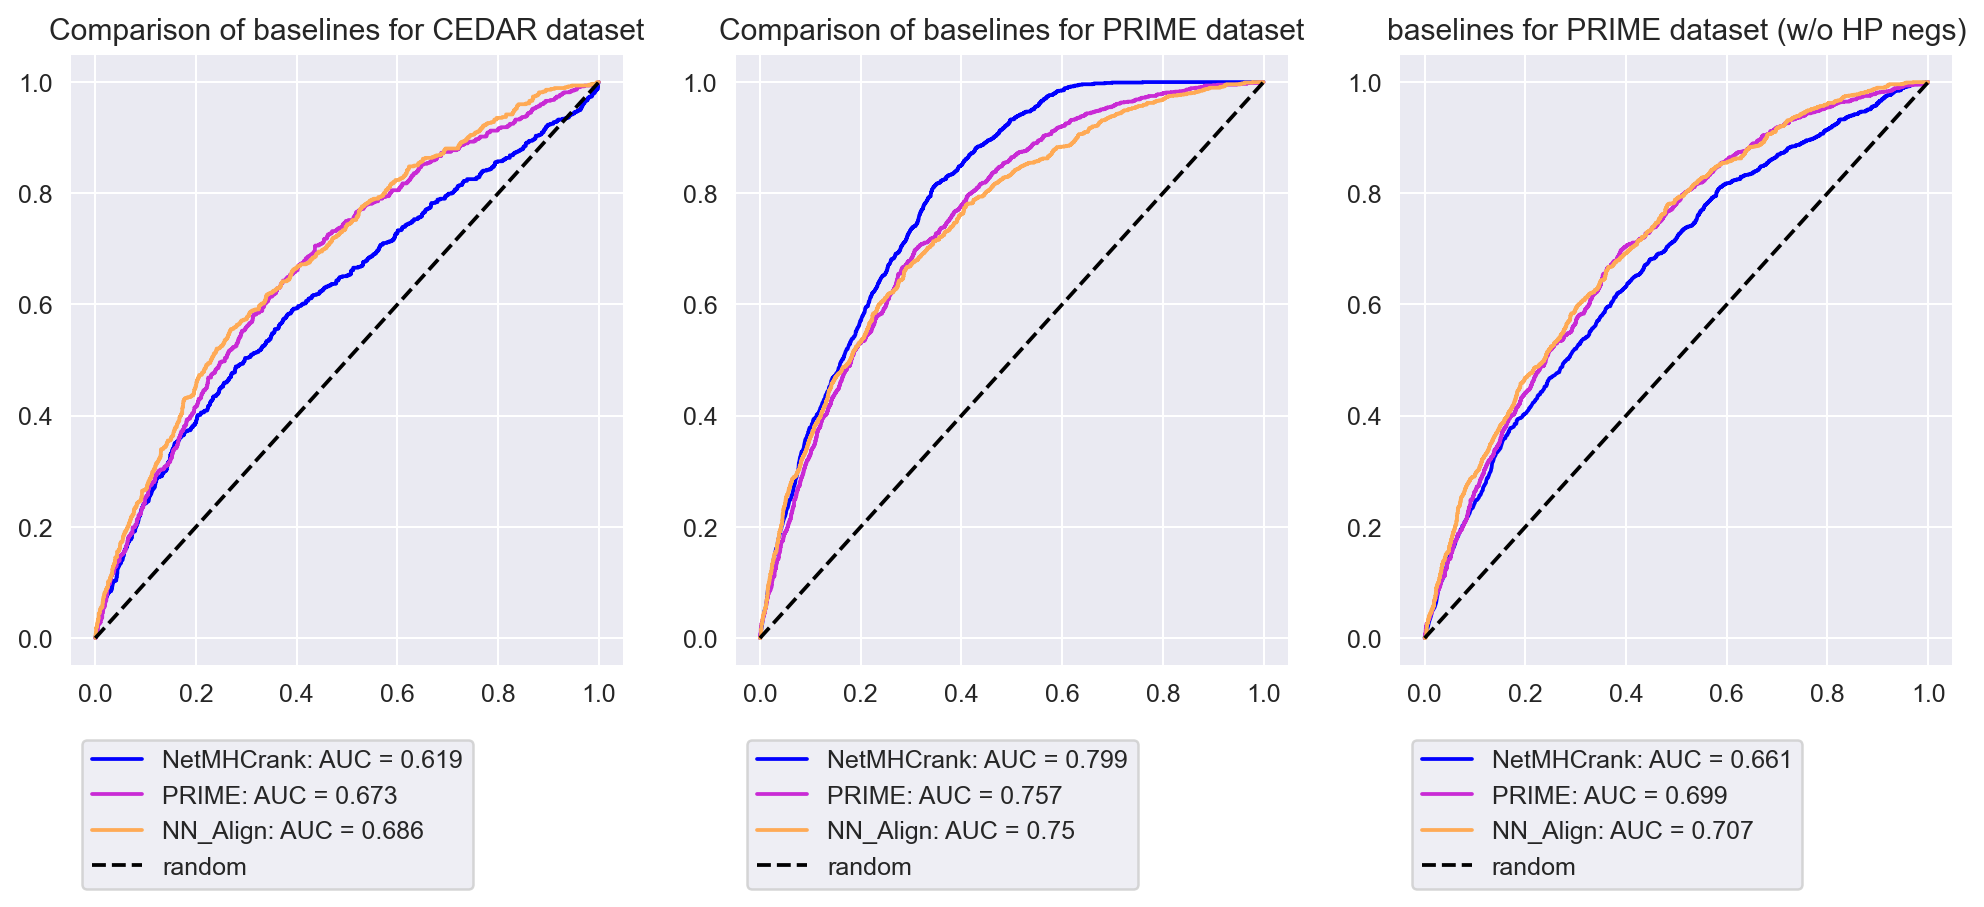

In [13]:
# For CEDAR
from sklearn.metrics import roc_auc_score, roc_curve
#FOR CEDAR
# EL rank
fpr_netmhc, tpr_netmhc, _ = roc_curve(cedar['agg_label'].values,  -1* cedar['trueHLA_EL_rank'].values)
auc_netmhc = roc_auc_score(cedar['agg_label'].values, -1*cedar['trueHLA_EL_rank'].values)
# PRIME
fpr_prime, tpr_prime, _ = roc_curve(cedar['agg_label'].values, cedar['PRIME_score'].values)
auc_prime = roc_auc_score(cedar['agg_label'].values, cedar['PRIME_score'].values)
# nnalign
fpr_nnalign, tpr_nnalign, _ = roc_curve(cedar['agg_label'].values, cedar['nnalign_score'].values)
auc_nnalign = roc_auc_score(cedar['agg_label'].values, cedar['nnalign_score'].values)

sns.set_palette('gnuplot2', n_colors=3)
f,a = plt.subplots(1,3, figsize=(13.5,4.5))
a[0].plot(fpr_netmhc, tpr_netmhc, label = f'NetMHCrank: AUC = {round(auc_netmhc,3)}')
a[0].plot(fpr_prime, tpr_prime, label = f'PRIME: AUC = {round(auc_prime,3)}')
a[0].plot(fpr_nnalign, tpr_nnalign, label = f'NN_Align: AUC = {round(auc_nnalign,3)}')
a[0].plot([0,1],[0,1], label='random', ls = '--', c='k')
a[0].legend(bbox_to_anchor=(0.75, -0.1))
a[0].set_title('Comparison of baselines for CEDAR dataset')
# FOR PRIME
# EL rank
fpr_netmhc, tpr_netmhc, _ = roc_curve(prime['Immunogenicity'].values,  -1* prime['NetMHCpanEL'].values)
auc_netmhc = roc_auc_score(prime['Immunogenicity'].values, -1*prime['NetMHCpanEL'].values)
# PRIME
fpr_prime, tpr_prime, _ = roc_curve(prime['Immunogenicity'].values, prime['PRIME_score'].values)
auc_prime = roc_auc_score(prime['Immunogenicity'].values, prime['PRIME_score'].values)
# nnalign
fpr_nnalign, tpr_nnalign, _ = roc_curve(prime['Immunogenicity'].values, prime['nnalign_score'].values)
auc_nnalign = roc_auc_score(prime['Immunogenicity'].values, prime['nnalign_score'].values)

a[1].plot(fpr_netmhc, tpr_netmhc, label = f'NetMHCrank: AUC = {round(auc_netmhc,3)}')
a[1].plot(fpr_prime, tpr_prime, label = f'PRIME: AUC = {round(auc_prime,3)}')
a[1].plot(fpr_nnalign, tpr_nnalign, label = f'NN_Align: AUC = {round(auc_nnalign,3)}')
a[1].plot([0,1],[0,1], label='random', ls = '--', c='k')
a[1].legend(bbox_to_anchor=(0.75, -0.1))
a[1].set_title('Comparison of baselines for PRIME dataset')


tmp = prime.query('StudyOrigin!="Random"')
fpr_netmhc, tpr_netmhc, _ = roc_curve(tmp['Immunogenicity'].values,  -1* tmp['NetMHCpanEL'].values)
auc_netmhc = roc_auc_score(tmp['Immunogenicity'].values, -1*tmp['NetMHCpanEL'].values)
# PRIME
fpr_prime, tpr_prime, _ = roc_curve(tmp['Immunogenicity'].values, tmp['PRIME_score'].values)
auc_prime = roc_auc_score(tmp['Immunogenicity'].values, tmp['PRIME_score'].values)
# nnalign
fpr_nnalign, tpr_nnalign, _ = roc_curve(tmp['Immunogenicity'].values, tmp['nnalign_score'].values)
auc_nnalign = roc_auc_score(tmp['Immunogenicity'].values, tmp['nnalign_score'].values)
a[2].plot(fpr_netmhc, tpr_netmhc, label = f'NetMHCrank: AUC = {round(auc_netmhc,3)}')
a[2].plot(fpr_prime, tpr_prime, label = f'PRIME: AUC = {round(auc_prime,3)}')
a[2].plot(fpr_nnalign, tpr_nnalign, label = f'NN_Align: AUC = {round(auc_nnalign,3)}')
a[2].plot([0,1],[0,1], label='random', ls = '--', c='k')
a[2].legend(bbox_to_anchor=(0.75, -0.1))
a[2].set_title('baselines for PRIME dataset (w/o HP negs)')

# Bootstrap

## fct defs

In [85]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, roc_curve, roc_auc_score
# PLOT BASELINE FUNCTIONS
def plot_baseline_roc(axis, dataset, remove_hp=False):
    if dataset=='cedar':
        fpr_netmhc, tpr_netmhc, _ = roc_curve(cedar['agg_label'].values,  -1* cedar['trueHLA_EL_rank'].values)
        auc_netmhc = roc_auc_score(cedar['agg_label'].values, -1*cedar['trueHLA_EL_rank'].values)
        # PRIME
        fpr_prime, tpr_prime, _ = roc_curve(cedar['agg_label'].values, cedar['PRIME_score'].values)
        auc_prime = roc_auc_score(cedar['agg_label'].values, cedar['PRIME_score'].values)
        # nnalign
        fpr_nnalign, tpr_nnalign, _ = roc_curve(cedar['agg_label'].values, cedar['nnalign_score'].values)
        auc_nnalign = roc_auc_score(cedar['agg_label'].values, cedar['nnalign_score'].values)
    elif dataset=='prime':
        
        tmp = prime.query('StudyOrigin != "Random"') if remove_hp else prime
        
        fpr_netmhc, tpr_netmhc, _ = roc_curve(tmp['Immunogenicity'].values,  -1* tmp['NetMHCpanEL'].values)
        auc_netmhc = roc_auc_score(tmp['Immunogenicity'].values, -1*tmp['NetMHCpanEL'].values)
        # PRIME
        fpr_prime, tpr_prime, _ = roc_curve(tmp['Immunogenicity'].values, tmp['PRIME_score'].values)
        auc_prime = roc_auc_score(tmp['Immunogenicity'].values, tmp['PRIME_score'].values)
        # nnalign
        fpr_nnalign, tpr_nnalign, _ = roc_curve(tmp['Immunogenicity'].values, tmp['nnalign_score'].values)
        auc_nnalign = roc_auc_score(tmp['Immunogenicity'].values, tmp['nnalign_score'].values)
    
    axis.plot(fpr_netmhc, tpr_netmhc, label = f'NetMHCrank: AUC = {round(auc_netmhc,3)}',
              linestyle='--', lw=0.75, color='m')
    axis.plot(fpr_prime, tpr_prime, label = f'PRIME: AUC = {round(auc_prime,3)}',
              linestyle='--', lw=0.75, color='g')
    axis.plot(fpr_nnalign, tpr_nnalign, label = f'NN_Align: AUC = {round(auc_nnalign,3)}',
              linestyle='--', lw=0.75, color='c')

    
def plot_baseline_pr(axis, dataset, remove_hp=False):
    if dataset=='cedar':
        precision_netmhc, recall_netmhc, _ = precision_recall_curve(cedar['agg_label'].values,  -1* cedar['trueHLA_EL_rank'].values)
        prauc_netmhc = auc(recall_netmhc, precision_netmhc)
        # PRIME
        precision_prime, recall_prime, _ = precision_recall_curve(cedar['agg_label'].values, cedar['PRIME_score'].values)
        prauc_prime = auc(recall_prime, precision_prime)
        # nnalign
        precision_nnalign, recall_nnalign, _ = precision_recall_curve(cedar['agg_label'].values, cedar['nnalign_score'].values)
        prauc_nnalign = auc(recall_nnalign, precision_nnalign)
        
    elif dataset=='prime':
        tmp = dataset.query('StudyOrigin != "Random"') if remove_hp else prime
        
        precision_netmhc, recall_netmhc, _ = precision_recall_curve(tmp['Immunogenicity'].values,  -1* tmp['NetMHCpanEL'].values)
        prauc_netmhc = auc(recall_netmhc, precision_netmhc)
        # PRIME
        precision_prime, recall_prime, _ = precision_recall_curve(tmp['Immunogenicity'].values, tmp['PRIME_score'].values)
        prauc_prime = auc(recall_prime, precision_prime)
        # nnalign
        precision_nnalign, recall_nnalign, _ = precision_recall_curve(tmp['Immunogenicity'].values, tmp['nnalign_score'].values)
        prauc_nnalign = auc(recall_nnalign, precision_nnalign)
    
    axis.plot(recall_netmhc, precision_netmhc, label = f'NetMHCrank: PRAUC = {round(prauc_netmhc,3)}',
              linestyle='-.', lw=0.45, color='m')
    axis.plot(recall_prime, precision_prime, label = f'PRIME: PRAUC = {round(prauc_prime,3)}',
              linestyle='-.', lw=0.45, color='g')
    axis.plot(recall_nnalign, precision_nnalign, label = f'NN_Align: PRAUC = {round(prauc_nnalign,3)}',
              linestyle='-.', lw=0.45, color='c')



In [33]:
# BOOTSTRAP FUNCTIONS
from joblib import Parallel, delayed
from functools import partial
from src.metrics import get_metrics


def bootstrap_wrapper(y_score, y_true, seed):    
    np.random.seed(seed)
    sample_idx = np.random.randint(0, len(y_score), len(y_score))
    sample_score = y_score[sample_idx]
    sample_true = y_true[sample_idx]
    
    test_results = get_metrics(sample_true, sample_score)
    
    # Save to get mean curves after
    roc_curve = (test_results.pop('roc_curve'), test_results['auc'])
    # Same
    pr_curve = (test_results.pop('pr_curve'), test_results['prauc'])
    return pd.DataFrame(test_results, index=[0]), roc_curve 


def bootstrap_eval(y_score, y_true, n_rounds=10000, n_jobs=16):
    wrapper = partial(bootstrap_wrapper, 
                      y_score=y_score, y_true=y_true)
    print('Sampling')
    output = Parallel(n_jobs=n_jobs)(delayed(wrapper)(seed=seed) for seed in tqdm(range(n_rounds), desc='Bootstrapping rounds', position=1))
    
    print('Making results DF and curves')
    result_df = pd.concat([x[0] for x in output])
    mean_roc_curve = get_mean_roc_curve([x[1] for x in output])
    # mean_pr_curve = get_mean_pr_curve([x[2] for x in output])
    return result_df, mean_roc_curve

def load_hyperparams(encoding_kwargs, train_dataset, MAPPING, model, blosum_matrix=None, weight = None):
    outdict = {'trainset': train_dataset['trainset'].unique()[0],
                       'model': MAPPING[model.__class__.__name__],
                       'weight': weight} # Hardcoded here
        
    outdict.update({k: v for k, v in encoding_kwargs.items() if k != 'blosum_matrix'})
    
    if blosum_matrix is not None:
        bl_name = 'BL62LO' if blosum_matrix['A'].dtype == np.int64 else 'BL62FREQ'
        outdict['blsm'] = bl_name
        
    outname = '_'.join([f'{k}{v}' for k, v in outdict.items()])
    
    if blosum_matrix is not None:
        bl_name = 'BL62LO' if blosum_matrix['A'].dtype == np.int64 else 'BL62FREQ'
        outdict['blsm'] = bl_name
        
    pkl_name = convert_path(os.path.join(f'../output/tuning/{MAPPING[model.__class__.__name__].lower()}_bootstrap', (outname + '.pkl')).replace('//', '/'))
    hyperparams = pkl_load(pkl_name)
    if 'max_depth' in hyperparams:
        if np.isnan(hyperparams['max_depth']):
            hyperparams['max_depth'] = None
        else:
    
            hyperparams['max_depth'] = int(hyperparams['max_depth'])
    
    for k in [x for x in hyperparams.keys() if x.startswith('n_')]:
        # converts n_estimators, n_layers, n_in, n_hidden, to int
        hyperparams[k] = int(hyperparams[k])
    return hyperparams

## Checking trainset - add_rank

### runs

In [71]:
all_results = {}
encoding_kwargs = {'max_len': 12,
                   'encoding': 'onehot',
                   'blosum_matrix': None,
                   'mask': False,  # Using Shannon ICs, true if both mask and name is "shannon"
                   'add_rank': False,
                   'add_aaprop': False,
                   'remove_pep': False,
                   'standardize': True}
blosum_matrix = None

tmp_prime = prime_fold.query('StudyOrigin != "Random"')


# DICT with multiple levels: 1 for add_rank, 1 more for model, 1 more for train_dataset, 1 more for df/curve
# --> all_results['True']['XGB']['cedar']['df_prime'] to get the results of prime

for add_rank in [True, False]:
    encoding_kwargs.update({'add_rank':add_rank})
    # All results['True']
    all_results[str(add_rank)] = {}
    for model in [XGBClassifier(verbosity=0, method='gpu_hist', n_jobs=1, subsample=0.75), 
                  RandomForestClassifier(n_jobs=1, min_samples_leaf = 7)]:
        # all_results['True']['XGB']
        all_results[str(add_rank)][MAPPING[model.__class__.__name__]] = {}
        
        for train_dataset in tqdm(
                                    [cedar,
                                     cedar_viral_old,
                                     cedar_viral_more,
                                     viral_only,
                                     prime_fold,
                                     cedar_hp_uni,
                                     cedar_hp_low
                                    ],
                                  desc = 'trainset', position=0):
            
            trainset_name = train_dataset.trainset.unique().item()
            # all_results['True']['XGB']['CEDAR'] = {}
            all_results[str(add_rank)][MAPPING[model.__class__.__name__]][trainset_name] = {}
            # Reload params
            hyperparams = load_hyperparams(encoding_kwargs, train_dataset, MAPPING, model, blosum_matrix)
            model.set_params(**hyperparams)
            
            trained_models, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model, ics_dict=None,
                                                            encoding_kwargs=encoding_kwargs)
            # EVAL + BOOTSTRAP ON CEDAR TEST SET
            _, concat_pred, concat_true = evaluate_trained_models_sklearn(test_dataframe=cedar, models_dict=trained_models, 
                                                                          ics_dict=None, train_dataframe=train_dataset,
                                                                          train_metrics=train_metrics, encoding_kwargs=encoding_kwargs,
                                                                          concatenated=True, return_scores=True)
                
            results_df, mean_rocs = bootstrap_eval(y_score = concat_pred,
                                                      y_true = concat_true, 
                                                      n_rounds=10000, n_jobs = 8)
            
            results_df['trainset'] = trainset_name
            results_df['model'] = MAPPING[model.__class__.__name__]
            
            all_results[str(add_rank)][MAPPING[model.__class__.__name__]][trainset_name]['df_cedar'] = results_df
            all_results[str(add_rank)][MAPPING[model.__class__.__name__]][trainset_name]['mean_rocs_cedar'] = mean_rocs
            # EVAL + BOOTSTRAP ON PRIME TEST SET
            _, concat_pred, concat_true = evaluate_trained_models_sklearn(test_dataframe=tmp_prime, models_dict=trained_models, 
                                                                          ics_dict=None, train_dataframe=train_dataset,
                                                                          train_metrics=train_metrics, encoding_kwargs=encoding_kwargs,
                                                                          concatenated=True, return_scores=True)
            results_df, mean_rocs = bootstrap_eval(y_score = concat_pred,
                                                      y_true = concat_true, 
                                                      n_rounds=10000, n_jobs = 8)
            results_df['trainset'] = trainset_name
            results_df['model'] = MAPPING[model.__class__.__name__]
            
            all_results[str(add_rank)][MAPPING[model.__class__.__name__]][trainset_name]['df_prime'] = results_df
            all_results[str(add_rank)][MAPPING[model.__class__.__name__]][trainset_name]['mean_rocs_prime'] = mean_rocs
            # results[trainset_name]['all_prs'] = all_prs
            
            
            all_results[str(add_rank)][MAPPING[model.__class__.__name__]][trainset_name]['model'] = trained_models
pkl_dump(all_results, '../output/bootstrapping/trainset_models.pkl')

trainset:   0%|          | 0/7 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


trainset:   0%|          | 0/7 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


trainset:   0%|          | 0/7 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


trainset:   0%|          | 0/7 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/bootstrapping/trainset_models.pkl saved.


In [72]:
df_rank_trainset_model_cedar = []
df_rank_trainset_model_prime = []

for add_rank in [True,False]:
    for model, value_model in all_results[str(add_rank)].items():
        for trainset, value_trainset in value_model.items():
            
            df_cedar = value_trainset['df_cedar']
            df_cedar['add_rank']=add_rank
            df_rank_trainset_model_cedar.append(df_cedar)
            
            df_prime = value_trainset['df_prime']
            df_prime['add_rank']=add_rank
            df_rank_trainset_model_prime.append(df_prime)
            
df_rank_trainset_model_cedar= pd.concat(df_rank_trainset_model_cedar)
df_rank_trainset_model_cedar.to_csv('../output/bootstrapping/df_rank_trainset_model_cedar.csv', index=False)
df_rank_trainset_model_prime= pd.concat(df_rank_trainset_model_prime)
df_rank_trainset_model_prime.to_csv('../output/bootstrapping/df_rank_trainset_model_prime.csv', index=False)

In [12]:
all_results = pkl_load('../output/bootstrapping/trainset_models.pkl')

In [13]:
df_rank_trainset_model_cedar = pd.read_csv('../output/bootstrapping/df_rank_trainset_model_cedar.csv')
df_rank_trainset_model_prime = pd.read_csv('../output/bootstrapping/df_rank_trainset_model_prime.csv')

### plots 

Text(0, 0.5, 'Test AUC (CEDAR)')

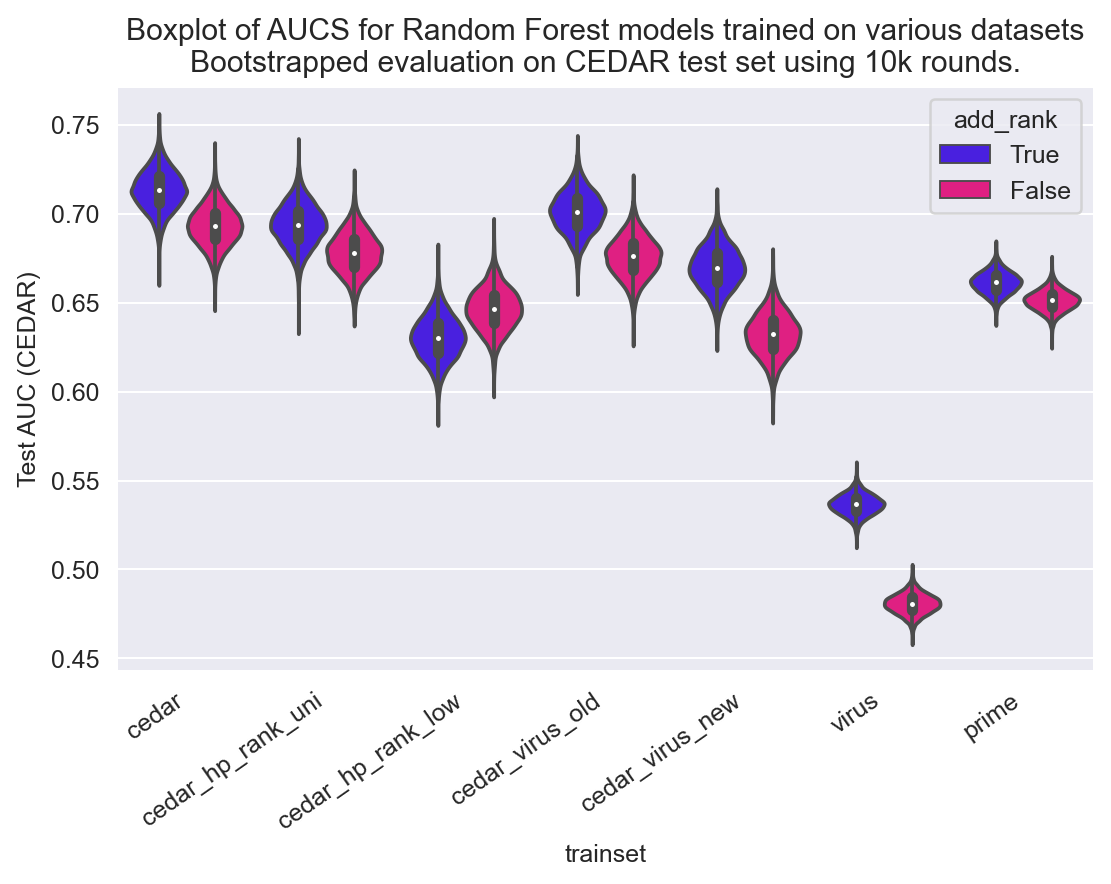

In [73]:
# Overall boxplot
f,a = plt.subplots(1,1, figsize=(7,4.3))
sns.set_palette([HSV[0], HSV[1]])
x_order = ['cedar', 'cedar_hp_rank_uni', 'cedar_hp_rank_low', 'cedar_virus_old', 'cedar_virus_new', 'virus', 'prime']
sns.violinplot(data=df_rank_trainset_model_cedar.query('model=="RF"'), ax=a, hue_order = [True, False],
            x='trainset', hue='add_rank', y='auc',
            order = x_order)
a.set_xticklabels(labels = x_order, rotation = 35, fontdict={'horizontalalignment':'right'})
a.set_title('Boxplot of AUCS for Random Forest models trained on various datasets\nBootstrapped evaluation on CEDAR test set using 10k rounds.')
a.set_ylabel('Test AUC (CEDAR)')

Text(0.5, 1.0, 'Bootstrapped AUC on CEDAR test set vs on PRIME test set\nFor different train sets\nUsing 10,000 rounds, RandomForest trained on amino-acid frequencies + %Rank')

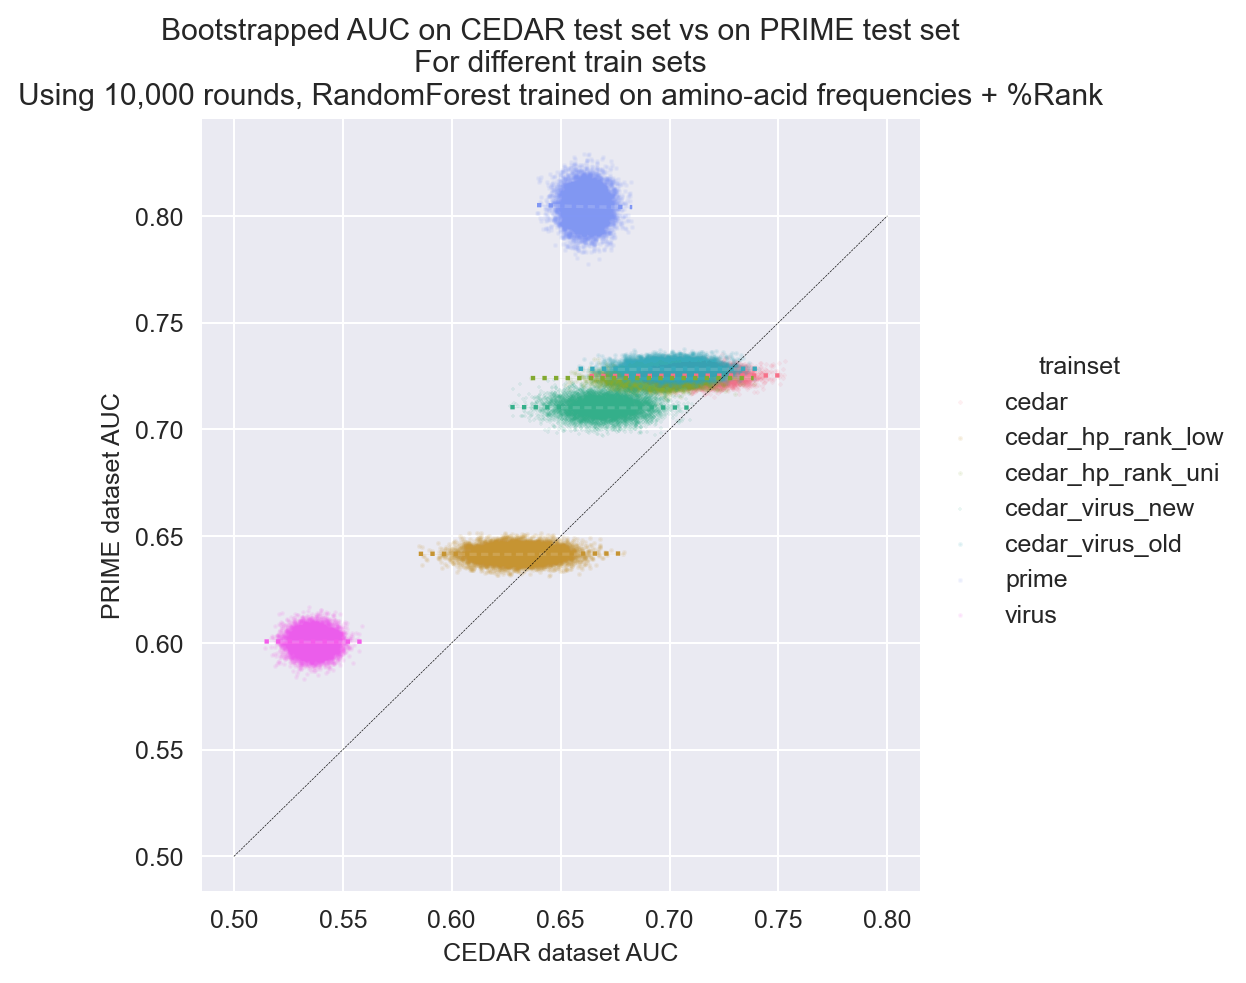

In [74]:
# X-Y lm plot
df_rank_trainset_concat = pd.merge(left=df_rank_trainset_model_cedar.rename(columns={'auc':'Score_CEDAR_AUC'})[['Score_CEDAR_AUC', 'trainset', 'model', 'add_rank']]\
                                                                .sort_values(['trainset','model','add_rank']).reset_index(drop=True),
                                    right=df_rank_trainset_model_prime.rename(columns={'auc':'Score_PRIME_AUC'})\
                                                                .sort_values(['trainset','model','add_rank']).reset_index(drop=True)['Score_PRIME_AUC'],
                                   left_index=True, right_index=True)


sns.set_palette(HSV)
f = plt.Figure(figsize=(7,7))

# f.set_axis_labels('CEDAR dataset AUC', 'PRIME dataset AUC')
sns.lmplot(data=df_rank_trainset_concat.query('add_rank==True and model=="RF"'),
           x='Score_CEDAR_AUC', y='Score_PRIME_AUC', hue='trainset',
           markers = ['x', 'o', '*', '+', '8', 's', 'p'], 
           scatter_kws={"alpha":0.1,"s":1}, line_kws={'lw':1.75,'ls':':'})

plt.plot([0.5,0.8],[0.5,.8], lw=0.25, ls='--', c='k')
plt.xlim = [0.55, 0.8]
plt.ylim = [0.55, 0.8]
plt.xlabel('CEDAR dataset AUC')
plt.ylabel('PRIME dataset AUC')

plt.title('Bootstrapped AUC on CEDAR test set vs on PRIME test set'\
           '\nFor different train sets'\
           '\nUsing 10,000 rounds, RandomForest trained on amino-acid frequencies + %Rank')

In [ ]:
# ROC PLOT
sns.set_palette(HSV, n_colors=7)
f,a = plt.subplots(1,1, figsize=(6,7.75), sharey=True)

for model in ['XGB', 'RF']:
    # RANK TRUE
    mean_cedar_roc = all_results[str(True)][model]['cedar']['mean_rocs_cedar']
    auc_01 =  all_results[str(True)][model]['cedar']['df_cedar']['auc_01'].mean()
    sns.lineplot(x=mean_cedar_roc[0],y=mean_cedar_roc[1], ax=a, 
                     label = f'{model} +%Rank={True}; AUC={round(mean_cedar_roc[4],3)}, AUC_01={round(auc_01,3)}', estimator=None)
    a.fill_between(np.linspace(0, 1, len(mean_cedar_roc[0])), mean_cedar_roc[2], mean_cedar_roc[3], alpha=0.15)
    # RANK FALSE
    mean_cedar_roc = all_results[str(False)][model]['cedar']['mean_rocs_cedar']
    auc_01 =  all_results[str(False)][model]['cedar']['df_cedar']['auc_01'].mean()
    sns.lineplot(x=mean_cedar_roc[0],y=mean_cedar_roc[1], ax=a, 
                     label = f'{model} +%Rank={False}; AUC={round(mean_cedar_roc[4],3)}, AUC_01={round(auc_01,3)}', estimator=None)
    a.fill_between(np.linspace(0, 1, len(mean_cedar_roc[0])), mean_cedar_roc[2], mean_cedar_roc[3], alpha=0.15)

a.plot([0,1], [0,1], ls = '--', lw= 0.5, label = 'Random prediction', c='k')
# a.legend(bbox_to_anchor = (1.05, .67))#
a.set_ylim([-.025,1.025])
a.set_xlim([-.025,1.025])
plot_baseline_roc(axis=a, dataset='cedar')
a.legend(bbox_to_anchor= (.825, -.091))
f.tight_layout()
a.set_xlabel('FPR')
a.set_ylabel('TPR')
a.set_title('Comparison of ROCs for different methods and adding Rank, trained on CEDAR\n'\
           'Bootstrapped evaluation on CEDAR test set using 10k rounds.', fontweight='semibold', fontsize=14)


Text(0.5, 0.98, 'Comparison of models and effect of adding rank.\nWith p-values of one-sided T-tests (n=10000)\nBootstrapped evaluation on CEDAR test set with 10k rounds')

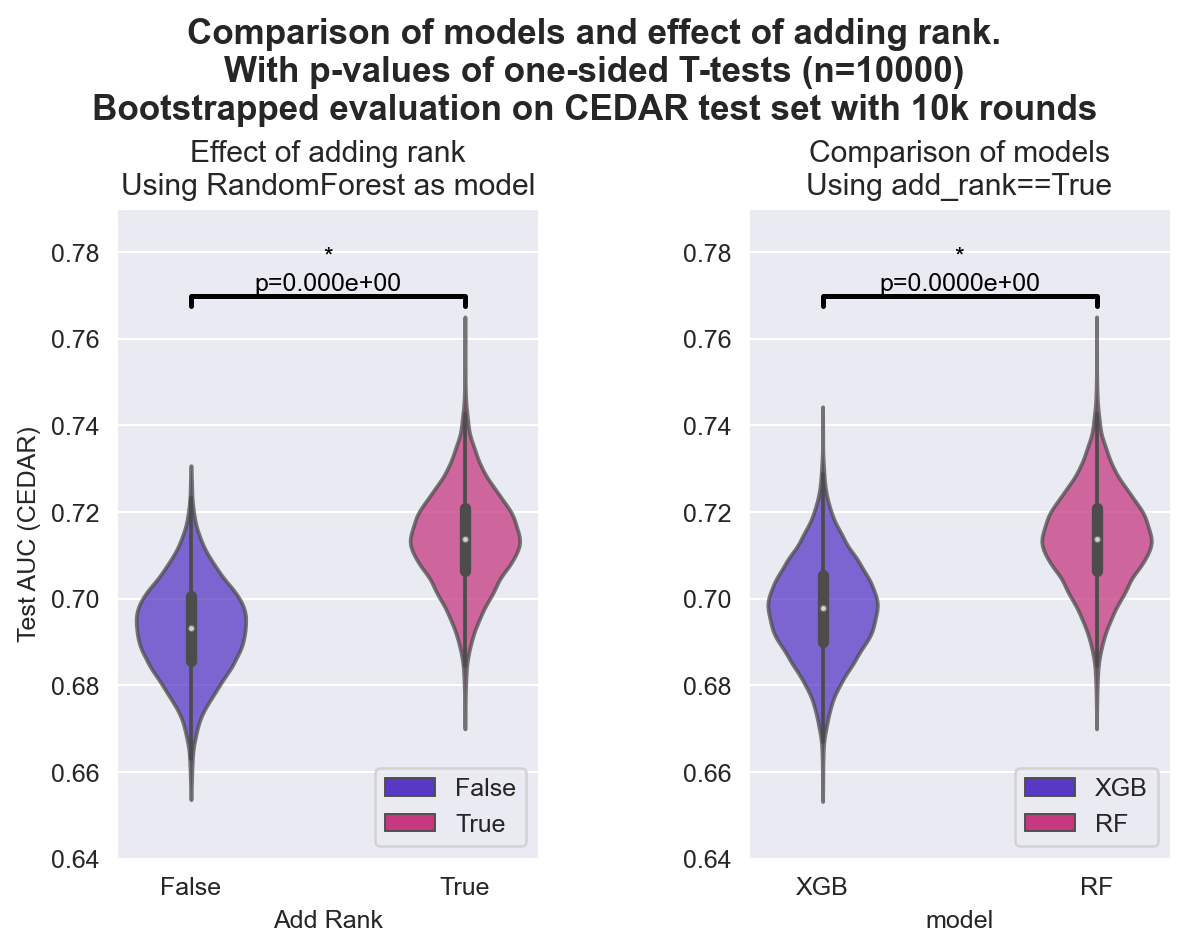

In [534]:
# LONE BOXPLOT WITH PVALUE
df_tmp = df_rank_trainset_model_cedar.query('trainset=="cedar" and model=="RF"').rename(columns={'auc':'CEDAR AUC',
                                                                                                 'add_rank': 'Add Rank'})
df_tmp2 = df_rank_trainset_model_cedar.query('trainset=="cedar" and add_rank==True').rename(columns={'auc':'CEDAR AUC'})
sns.set_palette(HSV)
f,a = plt.subplots(1,2, figsize=(8,6))

# FIRST (left boxplot to check Add Rank on CEDAR with pval)
sns.violinplot(data=df_tmp, x='Add Rank', y='CEDAR AUC', hue='Add Rank',  
            ax = a[0], saturation = 0.55, width = 0.4, cut=0, dodge=False,
              legend_kws = {'loc':'lower right'})#, boxprops=dict(alpha=.75))
plt.setp(a[0].collections, alpha=.75)

rank_true = df_tmp.query('`Add Rank`==True')['CEDAR AUC'].values
rank_false = df_tmp.query('`Add Rank`==False')['CEDAR AUC'].values
pval = ttest_ind(rank_true, rank_false, alternative='greater')[1]
label= f'*\np={pval:.3e}' if pval<0.025 else f'ns, p={pval:.3f}'
# Drawing Pval */ns rectangles
x1, x2 = 0, 1
y, h, col = .77-0.0025, 0.0025, 'k'
a[0].plot([x1,x1,x2,x2], [y, y+h, y+h, y], lw = 2, c=col)
a[0].set_ylim([0.64, 0.79])
a[0].text((x1+x2)*.5, y+h, label, ha = 'center', va = 'bottom', color = col)
a[0].legend(loc = 'lower right')
a[0].set_title('Effect of adding rank\nUsing RandomForest as model')


# FIRST (left boxplot to check Add Rank on CEDAR with pval
sns.violinplot(data=df_tmp2, x='model', y='CEDAR AUC', hue='model',  
            ax = a[1], saturation = 0.55, width = 0.4, dodge=False, cut=0,
               legend_kws = {'loc':'lower right'}
              )
# Manually sets the alpha for this collection in the axis a[1] object
plt.setp(a[1].collections, alpha=.75)
# sns.swarmplot(data= df_tmp2, x='model', y='CEDAR AUC', hue='model', 
              # ax = a[1], alpha = 0.6, size = 1.25, dodge=False)
a[0].set_ylabel('Test AUC (CEDAR)')
score_xgb = df_tmp2.query('model=="XGB"')['CEDAR AUC'].values
score_rf = df_tmp2.query('model=="RF"')['CEDAR AUC'].values
pval = ttest_ind(score_rf, score_xgb, alternative='greater')[1]
label= f'*\np={pval:.4e}' if pval<0.025 else f'ns, p={pval:.4f}'
# Drawing Pval */ns rectangles
x1, x2 = 0, 1
y, h, col = .77-0.0025, 0.0025, 'k'
a[1].set_ylabel(None)
a[1].plot([x1,x1,x2,x2], [y, y+h, y+h, y], lw = 2, c=col)
a[1].set_ylim([0.64, 0.79])
a[1].text((x1+x2)*.5, y+h, label, ha = 'center', va = 'bottom', color = col)
a[1].legend(loc = 'lower right')
a[1].set_title('Comparison of models\nUsing add_rank==True')
# a.set_title(binder)
f.tight_layout(pad=5.75)
f.suptitle('Comparison of models and effect of adding rank.\nWith p-values of one-sided T-tests (n=10000)\nBootstrapped evaluation on CEDAR test set with 10k rounds',
          fontweight='semibold', fontsize=14)

### REDO the violin p-values
Need to re-do the p-values, using the division thing from Morten instead

In [59]:
# Need to: Train on CEDAR only, do RandomForest, XGBoost, +/- Rank.

all_results = {}
encoding_kwargs = {'max_len': 12,
                   'encoding': 'onehot',
                   'blosum_matrix': None,
                   'mask': False,  
                   'add_rank': False,
                   'add_aaprop': False,
                   'remove_pep': False,
                   'standardize': True}
blosum_matrix = None

tmp_prime = prime_fold.query('StudyOrigin != "Random"')


# DICT with multiple levels: 1 for add_rank, 1 more for model, 1 more for train_dataset, 1 more for df/curve
# --> all_results['True']['XGB']['cedar']['df_prime'] to get the results of prime
dfs = []
for add_rank in [True, False]:
    encoding_kwargs.update({'add_rank':add_rank})
    # All results['True']
    all_results[str(add_rank)] = {}
    for model in [XGBClassifier(verbosity=0, method='hist', n_jobs=1, subsample=0.75), 
                  RandomForestClassifier(n_jobs=1, min_samples_leaf = 7)]:
        # all_results['True']['XGB']
        all_results[str(add_rank)][MAPPING[model.__class__.__name__]] = {}
        
        for train_dataset in tqdm(
                                    [cedar],
                                  desc = 'trainset', position=0):
            
            trainset_name = train_dataset.trainset.unique().item()
            # all_results['True']['XGB']['CEDAR'] = {}
            all_results[str(add_rank)][MAPPING[model.__class__.__name__]][trainset_name] = {}
            # Reload params
            hyperparams = load_hyperparams(encoding_kwargs, train_dataset, MAPPING, model, blosum_matrix)
            model.set_params(**hyperparams)
            
            trained_models, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model, ics_dict=None,
                                                            encoding_kwargs=encoding_kwargs)
            # EVAL + BOOTSTRAP ON CEDAR TEST SET
            _, concat_pred, concat_true = evaluate_trained_models_sklearn(test_dataframe=cedar, models_dict=trained_models, 
                                                                          ics_dict=None, train_dataframe=train_dataset,
                                                                          train_metrics=train_metrics, encoding_kwargs=encoding_kwargs,
                                                                          concatenated=True, return_scores=True)
                
            results_df, mean_rocs  = bootstrap_eval(y_score = concat_pred,
                                                      y_true = concat_true, 
                                                      n_rounds=10000, n_jobs = 8)
            
            results_df['trainset'] = trainset_name
            results_df['model'] = MAPPING[model.__class__.__name__]
            results_df['add_rank'] = add_rank
            # all_results[str(add_rank)][MAPPING[model.__class__.__name__]][trainset_name]['df_cedar'] = results_df
            all_results[str(add_rank)][MAPPING[model.__class__.__name__]][trainset_name]['mean_rocs_cedar'] = mean_rocs
            dfs.append(results_df)
            


trainset:   0%|          | 0/1 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


trainset:   0%|          | 0/1 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


trainset:   0%|          | 0/1 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


trainset:   0%|          | 0/1 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


In [60]:
df_rank_trainset_model_cedar = pd.concat(dfs)
df_rank_trainset_model_cedar.to_csv('../output/bootstrapping/df_pval_trainset_model_rank.csv')

Text(0.5, 0.98, 'Comparison of models and effect of adding rank.\nWith bootstrapped p-values (n=10000)\nBootstrapped evaluation on CEDAR test set with 10k rounds')

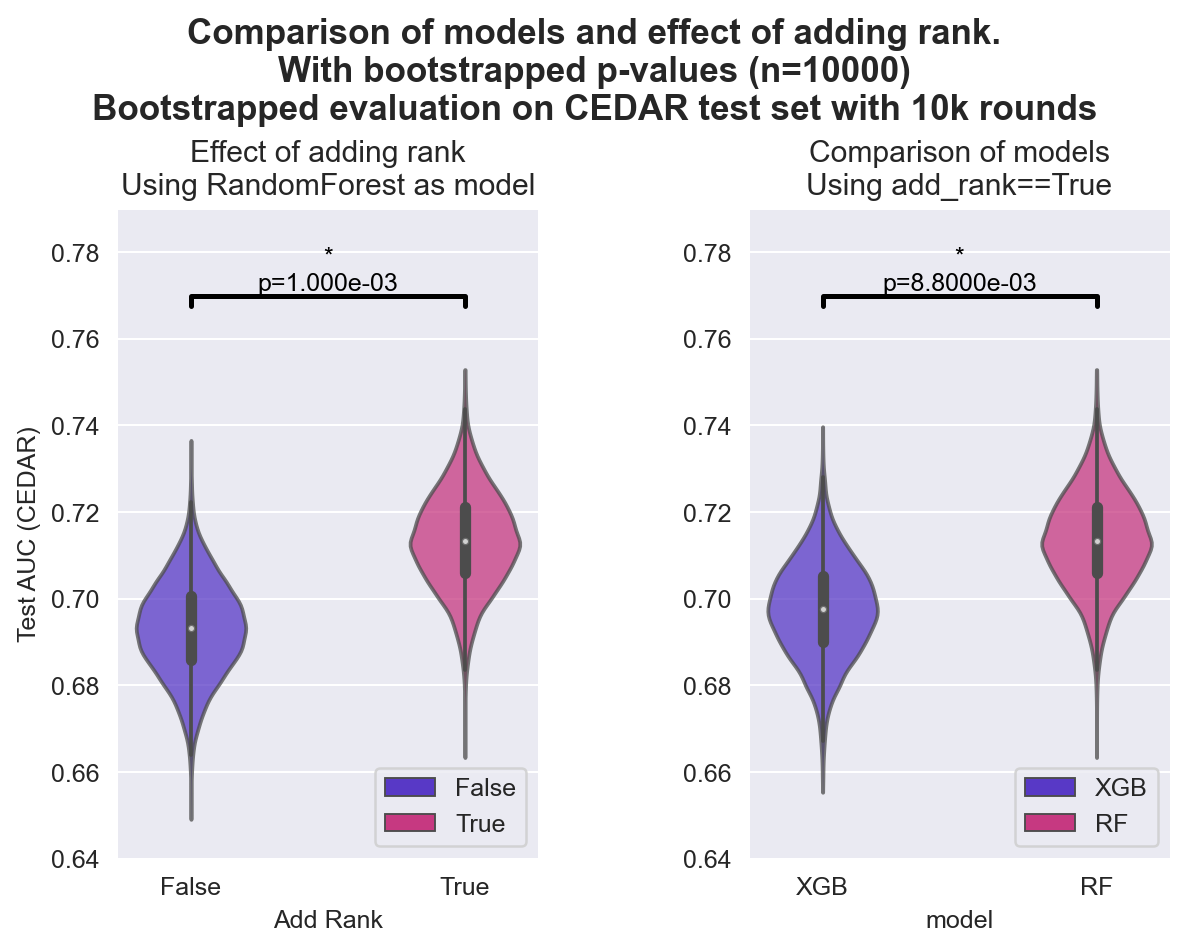

In [61]:
# LONE BOXPLOT WITH PVALUE
df_tmp = df_rank_trainset_model_cedar.query('trainset=="cedar" and model=="RF"').rename(columns={'auc':'CEDAR AUC',
                                                                                                 'add_rank': 'Add Rank'})
df_tmp2 = df_rank_trainset_model_cedar.query('trainset=="cedar" and add_rank==True').rename(columns={'auc':'CEDAR AUC'})
sns.set_palette(HSV)
f,a = plt.subplots(1,2, figsize=(8,6))

# FIRST (left boxplot to check Add Rank on CEDAR with pval)
sns.violinplot(data=df_tmp, x='Add Rank', y='CEDAR AUC', hue='Add Rank',  
            ax = a[0], saturation = 0.55, width = 0.4, cut=0, dodge=False,
              legend_kws = {'loc':'lower right'})#, boxprops=dict(alpha=.75))
plt.setp(a[0].collections, alpha=.75)

rank_true = df_tmp.query('`Add Rank`==True')['CEDAR AUC'].values
rank_false = df_tmp.query('`Add Rank`==False')['CEDAR AUC'].values
# pval = ttest_ind(rank_true, rank_false, alternative='greater')[1]
# New P-val calculation, 1 - M/N
pval = 1 - (len((rank_true>rank_false).astype(int).nonzero()[0]) / len(rank_true) )
label= f'*\np={pval:.3e}' if pval<0.025 else f'ns, p={pval:.3f}'
# Drawing Pval */ns rectangles
x1, x2 = 0, 1
y, h, col = .77-0.0025, 0.0025, 'k'
a[0].plot([x1,x1,x2,x2], [y, y+h, y+h, y], lw = 2, c=col)
a[0].set_ylim([0.64, 0.79])
a[0].text((x1+x2)*.5, y+h, label, ha = 'center', va = 'bottom', color = col)
a[0].legend(loc = 'lower right')
a[0].set_title('Effect of adding rank\nUsing RandomForest as model')


# FIRST (left boxplot to check Add Rank on CEDAR with pval
sns.violinplot(data=df_tmp2, x='model', y='CEDAR AUC', hue='model',  
            ax = a[1], saturation = 0.55, width = 0.4, dodge=False, cut=0,
               legend_kws = {'loc':'lower right'}
              )
# Manually sets the alpha for this collection in the axis a[1] object
plt.setp(a[1].collections, alpha=.75)
# sns.swarmplot(data= df_tmp2, x='model', y='CEDAR AUC', hue='model', 
              # ax = a[1], alpha = 0.6, size = 1.25, dodge=False)
a[0].set_ylabel('Test AUC (CEDAR)')
score_xgb = df_tmp2.query('model=="XGB"')['CEDAR AUC'].values
score_rf = df_tmp2.query('model=="RF"')['CEDAR AUC'].values

pval = 1 - (len((score_rf>score_xgb).astype(int).nonzero()[0]) / len(score_xgb) )
label= f'*\np={pval:.4e}' if pval<0.025 else f'ns, p={pval:.4f}'
# Drawing Pval */ns rectangles
x1, x2 = 0, 1
y, h, col = .77-0.0025, 0.0025, 'k'
a[1].set_ylabel(None)
a[1].plot([x1,x1,x2,x2], [y, y+h, y+h, y], lw = 2, c=col)
a[1].set_ylim([0.64, 0.79])
a[1].text((x1+x2)*.5, y+h, label, ha = 'center', va = 'bottom', color = col)
a[1].legend(loc = 'lower right')
a[1].set_title('Comparison of models\nUsing add_rank==True')
# a.set_title(binder)
f.tight_layout(pad=5.75)
f.suptitle('Comparison of models and effect of adding rank.\nWith bootstrapped p-values (n=10000)\nBootstrapped evaluation on CEDAR test set with 10k rounds',
          fontweight='semibold', fontsize=14)

## Checking Encoding & Weights

### runs

In [76]:
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES
encoding_kwargs = {'max_len': 12,
                   'encoding': 'onehot',
                   'blosum_matrix': None,
                   'mask': False,  # Using Shannon ICs, true if both mask and name is "shannon"
                   'add_rank': True,
                   'add_aaprop': False,
                   'remove_pep': False,
                   'standardize': True}
train_dataset = cedar
enc_weight_results = {}
model = RandomForestClassifier(n_jobs=1, min_samples_leaf = 7)
tmp_prime = prime_fold.query('StudyOrigin != "Random"')
for encoding, blosum_matrix, blsm_name in tqdm(zip(['onehot','blosum', 'blosum'], 
                                              [None, BL62_VALUES, BL62FREQ_VALUES],
                                              ['onehot','BL62LO', 'BL62FREQ']),
                                              desc = 'encoding', leave=True, position=0):
    
    encoding_kwargs['encoding']=encoding
    encoding_kwargs['blosum_matrix']=blosum_matrix
    
    enc_weight_results[blsm_name] = {}
    
    for ic_name, ics_dict in tqdm(zip(['Mask', 'KL', 'None', 'Shannon'], [ics_shannon, ics_kl, None, ics_shannon]),
                                 desc = 'Weighting', leave=True, position=1):
        encoding_kwargs['mask'] = True if ic_name =='Mask' else False
        
        enc_weight_results[blsm_name][ic_name]={}        
        trainset_name = train_dataset.trainset.unique().item()
        ###################################################
        # THIS BLOCK IS COPIED FROM THE NESTED KCV SCRIPT #
        ###################################################
        hyperparams = load_hyperparams(encoding_kwargs, train_dataset, MAPPING, model, blosum_matrix, weight=ic_name)
        model.set_params(**hyperparams)

        ###################################################
        trained_models, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model, ics_dict=ics_dict,
                                                        encoding_kwargs=encoding_kwargs)
        ############EVAL CEDAR############
        _, concat_pred, concat_true = evaluate_trained_models_sklearn(test_dataframe=cedar, models_dict=trained_models, 
                                                                      ics_dict=ics_dict, train_dataframe=train_dataset,
                                                                      train_metrics=train_metrics, encoding_kwargs=encoding_kwargs,
                                                                      concatenated=True, return_scores=True)
            
        results_df, mean_rocs = bootstrap_eval(y_score = concat_pred,
                                                  y_true = concat_true, 
                                                  n_rounds=10000, n_jobs = 8)

        results_df['trainset'] = trainset_name
        results_df['model'] = MAPPING[model.__class__.__name__]
        results_df['encoding'] = blsm_name
        results_df['weight'] = ic_name
        results_df.to_csv(f'../output/bootstrapping/{MAPPING[model.__class__.__name__]}_{trainset_name}_{blsm_name}_{ic_name}_cedar.csv', index=False)
        enc_weight_results[blsm_name][ic_name]['df_cedar'] = results_df
        enc_weight_results[blsm_name][ic_name]['mean_rocs_cedar'] = mean_rocs
        
        ###########EVAL PRIME ############
        _, concat_pred, concat_true = evaluate_trained_models_sklearn(test_dataframe=tmp_prime, models_dict=trained_models, 
                                                                      ics_dict=ics_dict, train_dataframe=train_dataset,
                                                                      train_metrics=train_metrics, encoding_kwargs=encoding_kwargs,
                                                                      concatenated=True, return_scores=True)
        results_df, mean_rocs = bootstrap_eval(y_score = concat_pred,
                                                  y_true = concat_true, 
                                                  n_rounds=10000, n_jobs = 8)

        results_df['trainset'] = trainset_name
        results_df['model'] = MAPPING[model.__class__.__name__]
        results_df['encoding'] = blsm_name
        results_df['weight'] = ic_name
        results_df.to_csv(f'../output/bootstrapping/{MAPPING[model.__class__.__name__]}_{trainset_name}_{blsm_name}_{ic_name}_prime.csv', index=False)
        enc_weight_results[blsm_name][ic_name]['df_prime'] = results_df
        enc_weight_results[blsm_name][ic_name]['mean_rocs_prime'] = mean_rocs
        
        enc_weight_results[blsm_name][ic_name]['model'] = trained_models
    

pkl_dump(enc_weight_results, '../output/bootstrapping/encoding_weighting.pkl')

encoding: 0it [00:00, ?it/s]

Weighting: 0it [00:00, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Weighting: 0it [00:00, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Weighting: 0it [00:00, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/bootstrapping/encoding_weighting.pkl saved.


In [77]:
df_encoding_weight_cedar = []
df_encoding_weight_prime = []
for key_encoding, v1 in enc_weight_results.items():
    for key_weight, value_weight in v1.items():
        df_cedar = value_weight['df_cedar']
        # df_cedar['add_rank']=add_rank
        df_encoding_weight_cedar.append(df_cedar)
        
        df_prime = value_weight['df_prime']
        # df_prime['add_rank']=add_rank
        df_encoding_weight_prime.append(df_prime)
        
df_encoding_weight_cedar= pd.concat(df_encoding_weight_cedar)
df_encoding_weight_cedar.to_csv('../output/bootstrapping/df_encoding_weight_cedar_rankTrue_modelRF_trainsetcedar.csv', index=False)
df_encoding_weight_prime= pd.concat(df_encoding_weight_prime)
df_encoding_weight_prime.to_csv('../output/bootstrapping/df_encoding_weight_prime_rankTrue_modelRF_trainsetcedar.csv', index=False)

### plots

In [47]:
enc_weight_results = pkl_load('../output/bootstrapping/encoding_weighting.pkl')

Text(0, 0.5, 'Test AUC (CEDAR)')

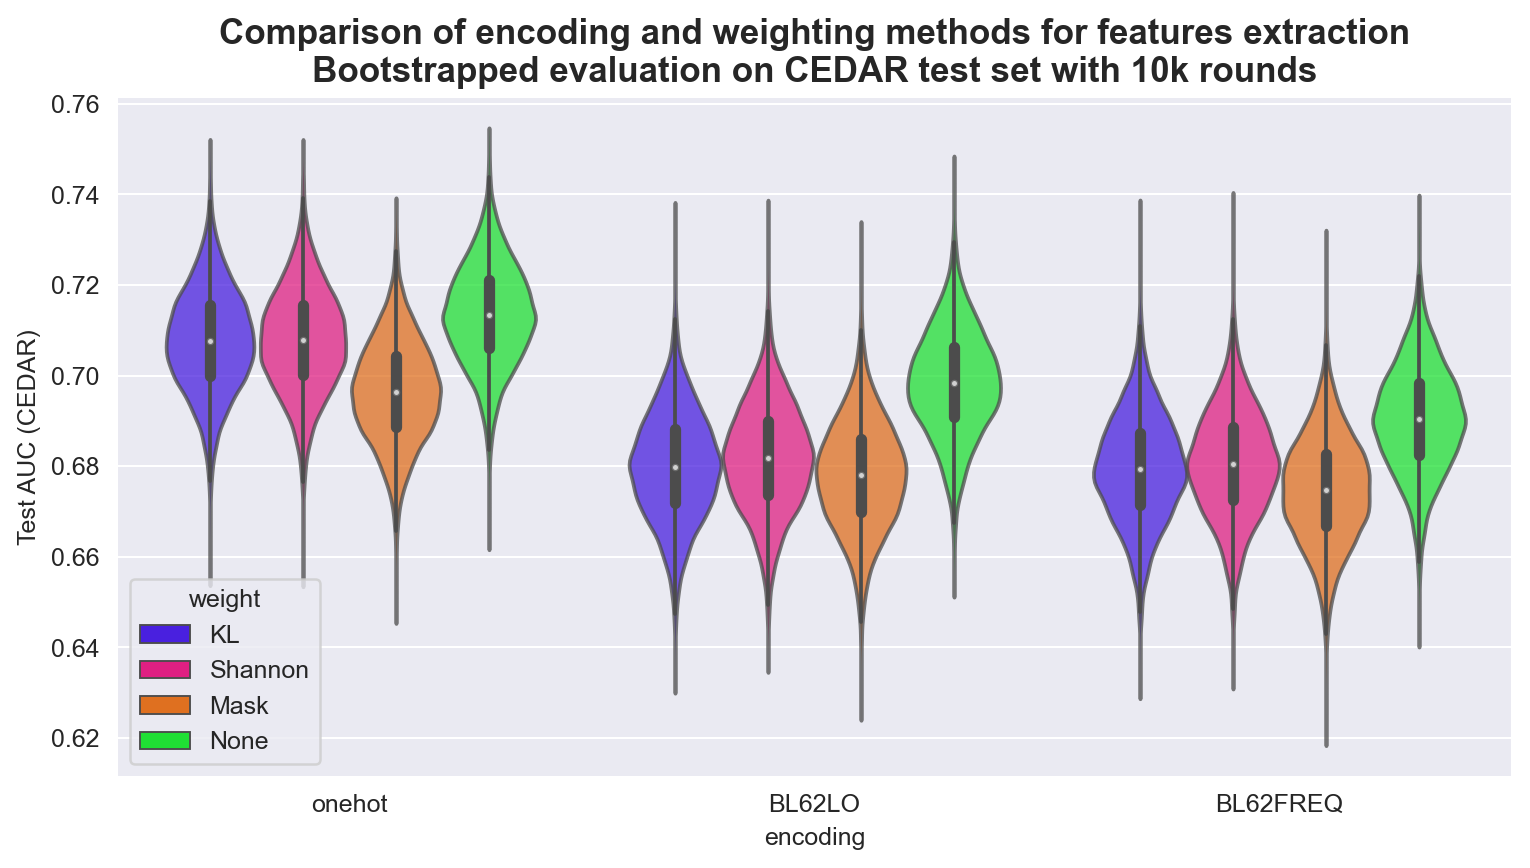

In [78]:
# VIOLINPLOTS WITHOUT PRIME
f,a = plt.subplots(1,1, figsize=(10,5))
sns.set_palette(HSV)
sns.violinplot(data= df_encoding_weight_cedar, x = 'encoding', hue='weight', y = 'auc', cut=1,
               dodge=True, width=.8, ax=a, hue_order = ['KL', 'Shannon', 'Mask', 'None'])
plt.setp(a.collections, alpha=.75)
a.set_title('Comparison of encoding and weighting methods for features extraction\nBootstrapped evaluation on CEDAR test set with 10k rounds',
           fontweight='semibold', fontsize=14)
a.set_ylabel('Test AUC (CEDAR)')
 

In [79]:
df_encoding_weight_cedar.groupby(['encoding', 'weight']).agg(mean_cedar_auc = ('auc', 'mean'),
                                                             max_cedar_auc = ('auc', 'max'),
                                                             std_cedar_auc = ('auc', 'std')).sort_values('mean_cedar_auc', ascending=False)

mean_cedar_auc  max_cedar_auc  std_cedar_auc
encoding weight                                               
onehot   None           0.713448       0.752886       0.011204
         Shannon        0.707796       0.750278       0.011494
         KL             0.707674       0.750302       0.011448
BL62LO   None           0.698397       0.746582       0.011786
onehot   Mask           0.696443       0.737424       0.011337
BL62FREQ None           0.690418       0.737941       0.011867
BL62LO   Shannon        0.681687       0.736812       0.011970
BL62FREQ Shannon        0.680474       0.738529       0.011840
BL62LO   KL             0.679898       0.736311       0.011977
BL62FREQ KL             0.679440       0.736858       0.011876
BL62LO   Mask           0.677896       0.732098       0.011850
BL62FREQ Mask           0.674728       0.730218       0.011768

Text(0.5, 0.98, 'Comparison of top two methods (OneHot-encoding and Shannon/None weight)\nWith p-values of one-sided T-tests (n=10000)\nBootstrapped evaluation on CEDAR test set with 10k rounds')

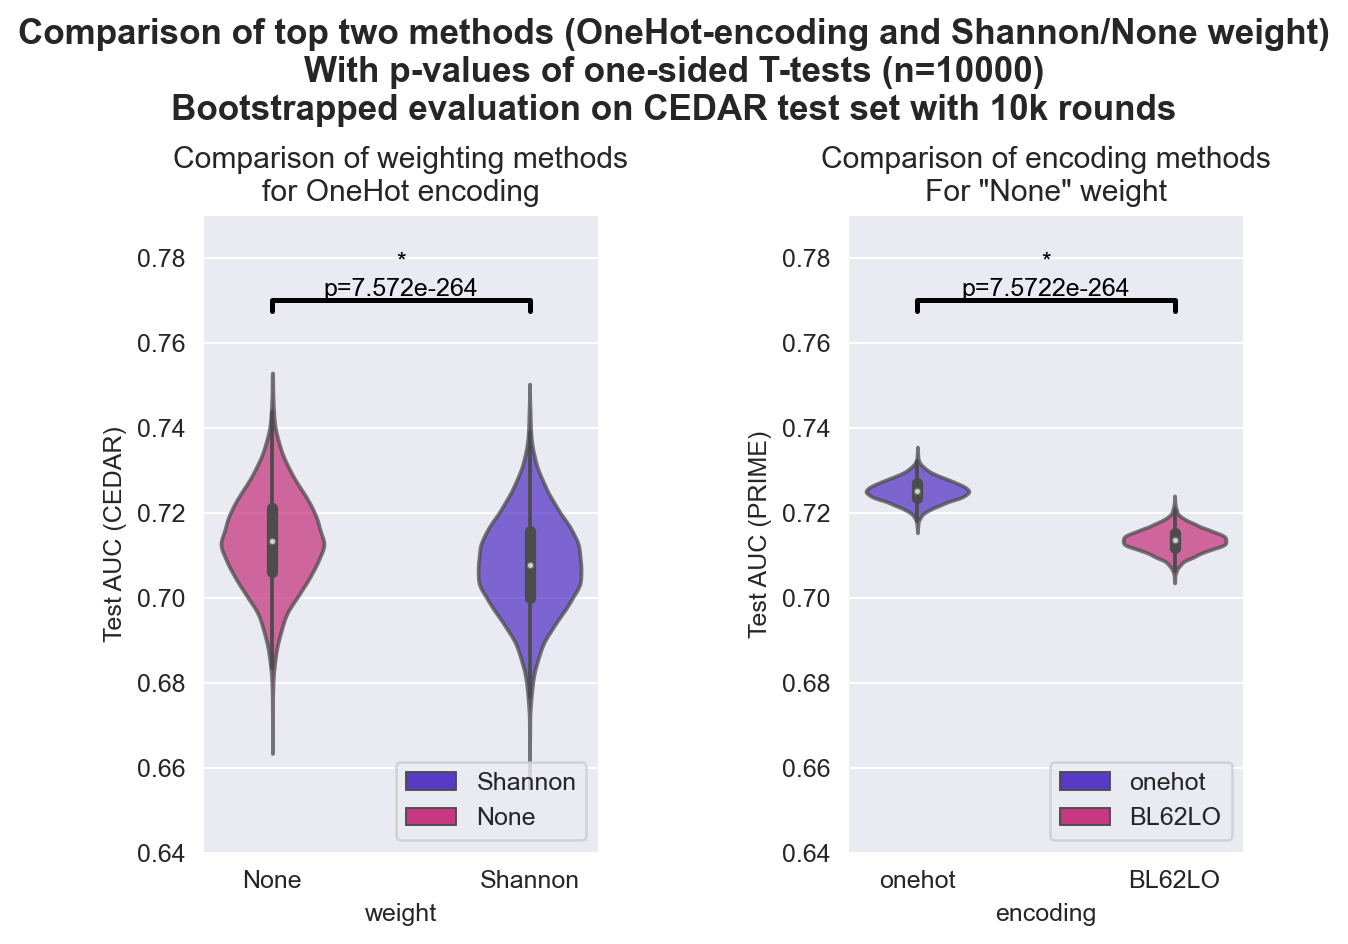

In [80]:
# LONE BOXPLOT WITH PVALUE 
# Comparing Onehot-None vs Onehot-Shannon (Shannon has a bigger max but lower mean)
df_tmp = df_encoding_weight_cedar.query('encoding=="onehot" and weight in ["Shannon", "None"]')
df_tmp2 = df_encoding_weight_prime.query('encoding in ["onehot", "BL62LO"] and weight in ["None"]')

sns.set_palette(HSV)
f,a = plt.subplots(1,2, figsize=(8,6))

#############################################################
# FIRST (left boxplot to check Add Rank on CEDAR with pval) #
#############################################################

sns.violinplot(data=df_tmp, x='weight', y='auc', hue='weight', hue_order = ['Shannon', 'None'],
            ax = a[0], saturation = 0.55, width = 0.4, cut=0, dodge=False,
              legend_kws = {'loc':'lower right'})#, boxprops=dict(alpha=.75))
plt.setp(a[0].collections, alpha=.75)
# PVALUES
df_shannon = df_tmp.query('weight=="Shannon"')['auc'].values
# df_kl = df_tmp.query('weight=="Shannon"')['auc'].values
df_none = df_tmp.query('weight=="None"')['auc'].values
pval = ttest_ind(df_none, df_shannon, alternative='greater')[1]
# pval_shannon_kl = ttest_ind(df_shannon, df_kl, alternative='greater')[1]
label = f'*\np={pval:.3e}' if pval<0.025 else f'ns, p={pval:.3f}'
# label_shannon_kl = f'*\np={pval_shannon_kl:.3e}' if pval<0.025 else f'ns, p={pval_shannon_kl:.3f}'

# Drawing Pval */ns rectangles
x1, x2 = 0, 1
y, h, col = .77-0.0025, 0.0025, 'k'
a[0].plot([x1,x1,x2,x2], [y, y+h, y+h, y], lw = 2, c=col)
a[0].set_ylim([0.64, 0.79])
a[0].text((x1+x2)*.5, y+h, label, ha = 'center', va = 'bottom', color = col)
a[0].legend(loc = 'lower right')
a[0].set_title('Comparison of weighting methods\nfor OneHot encoding')


#############################################################
#                          2ND                              #
#############################################################
sns.violinplot(data=df_tmp2, x='encoding', y='auc', hue='encoding', hue_order = ['onehot', 'BL62LO'],
            ax = a[1], saturation = 0.55, width = 0.4, dodge=False, cut=0,
               legend_kws = {'loc':'lower right'}
              )
# Manually sets the alpha for this collection in the axis a[1] object
plt.setp(a[1].collections, alpha=.75)
# sns.swarmplot(data= df_tmp2, x='model', y='CEDAR AUC', hue='model', 
              # ax = a[1], alpha = 0.6, size = 1.25, dodge=False)
a[0].set_ylabel('Test AUC (CEDAR)')
df_shannon = df_tmp2.query('encoding=="onehot"')['auc'].values
df_none = df_tmp2.query('encoding=="BL62LO"')['auc'].values
pval_shannon_none = ttest_ind(df_none, df_shannon, alternative='greater')[1]
label= f'*\np={pval:.4e}' if pval<0.025 else f'ns, p={pval:.4f}'
# Drawing Pval */ns rectangles
x1, x2 = 0, 1
y, h, col = .77-0.0025, 0.0025, 'k'
a[1].set_ylabel('Test AUC (PRIME)')
a[1].plot([x1,x1,x2,x2], [y, y+h, y+h, y], lw = 2, c=col)
a[1].set_ylim([0.64, 0.79])
a[1].text((x1+x2)*.5, y+h, label, ha = 'center', va = 'bottom', color = col)
a[1].legend(loc = 'lower right')
a[1].set_title('Comparison of encoding methods\nFor "None" weight')
# a.set_title(binder)
f.tight_layout(pad=6)
f.suptitle('Comparison of top two methods (OneHot-encoding and Shannon/None weight)\nWith p-values of one-sided T-tests (n=10000)\nBootstrapped evaluation on CEDAR test set with 10k rounds',
          fontweight='semibold', fontsize=14)

Text(0.5, 1.0, 'Comparison of ROCs for the top two Weight-Encoding pair\nBootstrapped evaluation on CEDAR test set using 10k rounds.')

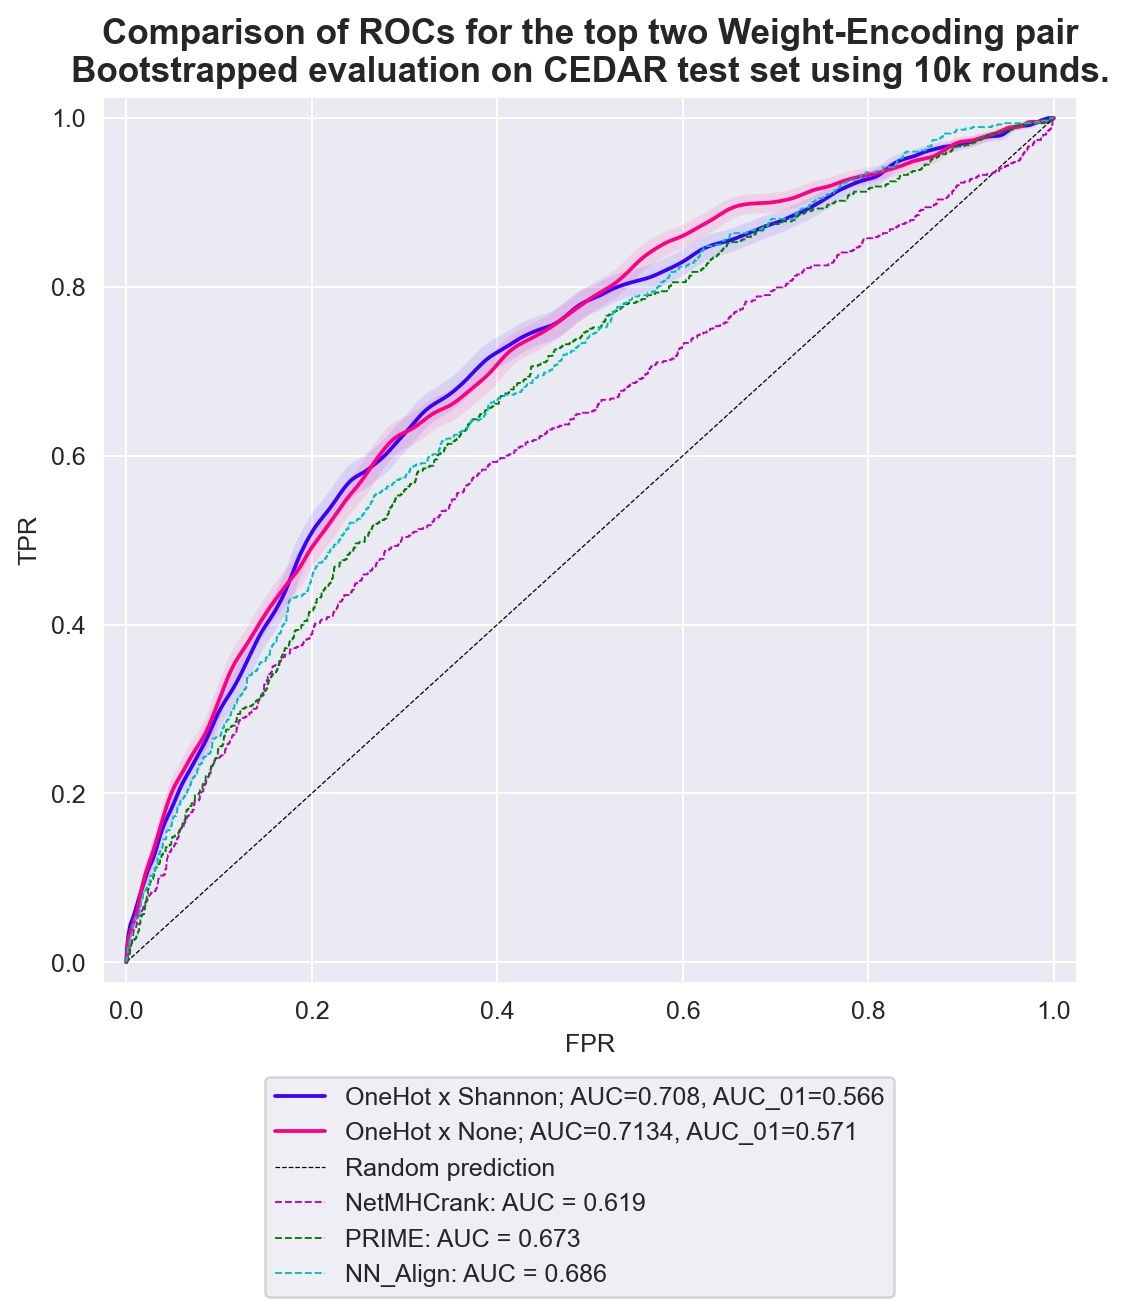

In [81]:
shannon_roc = enc_weight_results['onehot']['Shannon']['mean_rocs_cedar']
shannon_auc01 = enc_weight_results['onehot']['Shannon']['df_cedar']['auc_01'].mean()
none_roc = enc_weight_results['onehot']['None']['mean_rocs_cedar']
none_auc01 = enc_weight_results['onehot']['None']['df_cedar']['auc_01'].mean()
# ROC PLOT
sns.set_palette(HSV)
f,a = plt.subplots(1,1, figsize=(6,7.), sharey=True)

sns.lineplot(x=shannon_roc[0],y=shannon_roc[1], ax=a, 
                 label = f'OneHot x Shannon; AUC={round(shannon_roc[4],3)}, AUC_01={round(shannon_auc01,3)}', estimator=None)
a.fill_between(np.linspace(0, 1, len(shannon_roc[0])), shannon_roc[2], shannon_roc[3], alpha=0.1)
    
sns.lineplot(x=none_roc[0],y=none_roc[1], ax=a, 
                 label = f'OneHot x None; AUC={round(none_roc[4],4)}, AUC_01={round(none_auc01,3)}', estimator=None)
a.fill_between(np.linspace(0, 1, len(none_roc[0])), none_roc[2], none_roc[3], alpha=0.1)

a.plot([0,1], [0,1], ls = '--', lw= 0.5, label = 'Random prediction', c='k')
# a.legend(bbox_to_anchor = (1.05, .67))#
a.set_ylim([-.025,1.025])
a.set_xlim([-.025,1.025])
plot_baseline_roc(axis=a, dataset='cedar')
a.legend(bbox_to_anchor= (.825, -.091))
f.tight_layout()
a.set_xlabel('FPR')
a.set_ylabel('TPR')
a.set_title('Comparison of ROCs for the top two Weight-Encoding pair\n'\
           'Bootstrapped evaluation on CEDAR test set using 10k rounds.', fontweight='semibold', fontsize=14)


### Here need to redo the pvalue thing again

In [62]:
# REDO SELECTED RUNS: (OneHot x [Shannon vs None], None x [OneHot vs BL62LO])
# --> OneHot-Shannon, OneHot-None, None-BL62LO
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES
encoding_kwargs = {'max_len': 12,
                   'encoding': 'onehot',
                   'blosum_matrix': None,
                   'mask': False,  # Using Shannon ICs, true if both mask and name is "shannon"
                   'add_rank': True,
                   'add_aaprop': False,
                   'remove_pep': False,
                   'standardize': True}
train_dataset = cedar
dfs = []
# RERUN BOOTSTRAP FOR PVALUE COMP
model = RandomForestClassifier(n_jobs=1, min_samples_leaf = 7)
for encoding, blosum_matrix, blsm_name, ic_name, ics_dict in tqdm(zip(['onehot', 'blosum', 'onehot'], 
                                                                      [None, BL62_VALUES, None],
                                                                      ['onehot', 'BL62LO', 'onehot'],
                                                                      ['Shannon',  'None', 'None'],
                                                                      [ics_shannon,  None, None]),
                                              desc = 'encoding', leave=True, position=0):
    
    encoding_kwargs['encoding']=encoding
    encoding_kwargs['blosum_matrix']=blosum_matrix
    hyperparams = load_hyperparams(encoding_kwargs, train_dataset, MAPPING, model, blosum_matrix, weight=ic_name)
    model.set_params(**hyperparams)
    ###################################################
    trained_models, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model, ics_dict=ics_dict,
                                                    encoding_kwargs=encoding_kwargs)
    ############   EVAL CEDAR   ############
    _, concat_pred, concat_true = evaluate_trained_models_sklearn(test_dataframe=cedar, models_dict=trained_models, 
                                                                  ics_dict=ics_dict, train_dataframe=train_dataset,
                                                                  train_metrics=train_metrics, encoding_kwargs=encoding_kwargs,
                                                                  concatenated=True, return_scores=True)

    results_df, mean_rocs = bootstrap_eval(y_score = concat_pred,
                                              y_true = concat_true, 
                                              n_rounds=10000, n_jobs = 8)

    results_df['model'] = MAPPING[model.__class__.__name__]
    results_df['encoding'] = blsm_name
    results_df['weight'] = ic_name
    dfs.append(results_df)
    # enc_weight_results[blsm_name][ic_name]['df_cedar'] = results_df
    # enc_weight_results[blsm_name][ic_name]['mean_rocs_cedar'] = mean_rocs


encoding: 0it [00:00, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


In [63]:
df_encoding_weight_cedar = pd.concat(dfs)
df_encoding_weight_cedar.to_csv('../output/bootstrapping/df_pval_redo_encoding_weight.csv')
df_tmp = df_encoding_weight_cedar.query('encoding=="onehot" and weight in ["Shannon", "None"]')
df_tmp2 = df_encoding_weight_cedar.query('encoding in ["onehot", "BL62LO"] and weight in ["None"]')



Text(0.5, 0.98, 'Comparison of top two methods (OneHot-encoding and Shannon/None weight)\nWith bootstrapped p-values (n=10000)\nBootstrapped evaluation on CEDAR test set with 10k rounds')

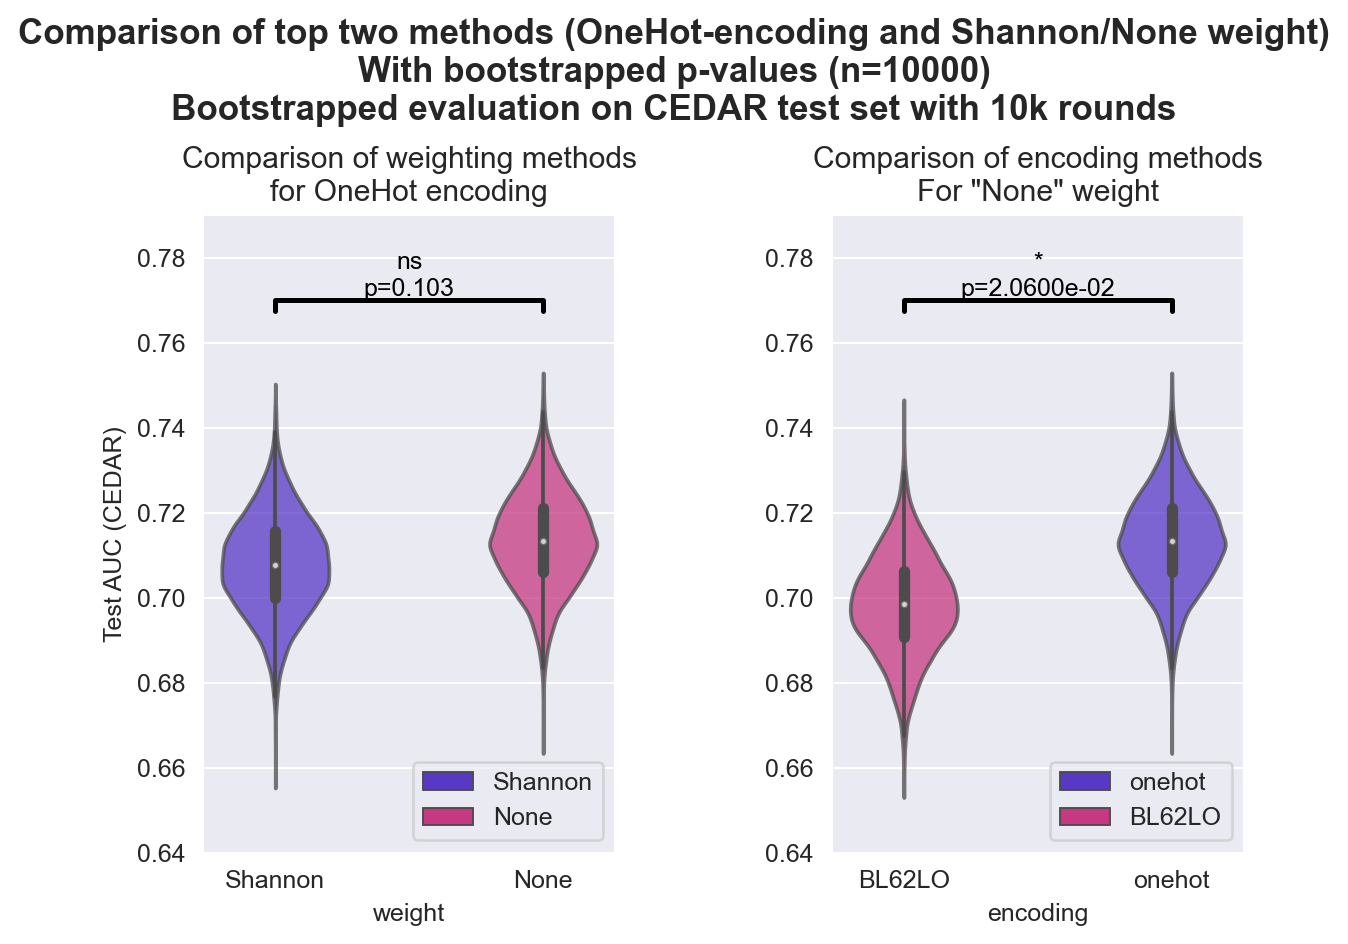

In [66]:
# LONE BOXPLOT WITH PVALUE 
# Comparing Onehot-None vs Onehot-Shannon (Shannon has a bigger max but lower mean)
df_tmp = df_encoding_weight_cedar.query('encoding=="onehot" and weight in ["Shannon", "None"]')
df_tmp2 = df_encoding_weight_cedar.query('encoding in ["onehot", "BL62LO"] and weight in ["None"]')

sns.set_palette(HSV)
f,a = plt.subplots(1,2, figsize=(8,6))

#############################################################
# FIRST (left boxplot to check Add Rank on CEDAR with pval) #
#############################################################

sns.violinplot(data=df_tmp, x='weight', y='auc', hue='weight', hue_order = ['Shannon', 'None'],
            ax = a[0], saturation = 0.55, width = 0.4, cut=0, dodge=False,
              legend_kws = {'loc':'lower right'})#, boxprops=dict(alpha=.75))
plt.setp(a[0].collections, alpha=.75)
# PVALUES
df_shannon = df_tmp.query('weight=="Shannon"')['auc'].values
df_none = df_tmp.query('weight=="None"')['auc'].values

pval = 1 - (len((df_none>df_shannon).astype(int).nonzero()[0]) / len(df_shannon) )
label = f'*\np={pval:.3e}' if pval<0.025 else f'ns\np={pval:.3f}'

# Drawing Pval */ns rectangles
x1, x2 = 0, 1
y, h, col = .77-0.0025, 0.0025, 'k'
a[0].plot([x1,x1,x2,x2], [y, y+h, y+h, y], lw = 2, c=col)
a[0].set_ylim([0.64, 0.79])
a[0].text((x1+x2)*.5, y+h, label, ha = 'center', va = 'bottom', color = col)
a[0].legend(loc = 'lower right')
a[0].set_title('Comparison of weighting methods\nfor OneHot encoding')


#############################################################
#                          2ND                              #
#############################################################
sns.violinplot(data=df_tmp2, x='encoding', y='auc', hue='encoding', hue_order = ['onehot', 'BL62LO'],
            ax = a[1], saturation = 0.55, width = 0.4, dodge=False, cut=0,
               legend_kws = {'loc':'lower right'}
              )
# Manually sets the alpha for this collection in the axis a[1] object
plt.setp(a[1].collections, alpha=.75)
# sns.swarmplot(data= df_tmp2, x='model', y='CEDAR AUC', hue='model', 
              # ax = a[1], alpha = 0.6, size = 1.25, dodge=False)
a[0].set_ylabel('Test AUC (CEDAR)')
df_onehot = df_tmp2.query('encoding=="onehot"')['auc'].values
df_blosum = df_tmp2.query('encoding=="BL62LO"')['auc'].values
pval = 1 - (len((df_onehot>df_blosum).astype(int).nonzero()[0]) / len(df_blosum) )
label= f'*\np={pval:.4e}' if pval<0.025 else f'ns\np={pval:.4f}'
# Drawing Pval */ns rectangles
x1, x2 = 0, 1
y, h, col = .77-0.0025, 0.0025, 'k'
a[1].set_ylabel(None)
a[1].plot([x1,x1,x2,x2], [y, y+h, y+h, y], lw = 2, c=col)
a[1].set_ylim([0.64, 0.79])
a[1].text((x1+x2)*.5, y+h, label, ha = 'center', va = 'bottom', color = col)
a[1].legend(loc = 'lower right')
a[1].set_title('Comparison of encoding methods\nFor "None" weight')
# a.set_title(binder)
f.tight_layout(pad=6)
f.suptitle('Comparison of top two methods (OneHot-encoding and Shannon/None weight)\nWith bootstrapped p-values (n=10000)\nBootstrapped evaluation on CEDAR test set with 10k rounds',
          fontweight='semibold', fontsize=14)

## check PC props

In [83]:
combo = zip([True, True, False, False, True],
            [True, False, True, False, True],
            [False, False, False, False, True])

encoding_kwargs = {'max_len':12, 
                   'encoding':'onehot',
                   'blosum_matrix':None,
                   'mask': False,
                   'mask':None,
                   'add_rank':None,
                   'add_aaprop':None,
                   'remove_pep':None,
                   'standardize':True}

train_dataset = cedar
model=RandomForestClassifier(n_jobs=15, min_samples_leaf=7)
tmp_prime = prime_fold.query('StudyOrigin!="Random"')
trainset_name = 'cedar'
for ic_name, ics_dict in tqdm(zip(['Shannon'], [ics_shannon]),
                                 desc = 'Weighting', leave=True, position=1):
    for add_rank, add_aaprop, remove_pep in combo:
        res = {}
        res['ic_name'] = ic_name
        res['add_rank'] = add_rank
        res['add_aaprop'] = add_aaprop
        res['remove_pep'] = remove_pep
        encoding_kwargs['mask'] = True if ic_name=='Mask' else False
        encoding_kwargs['add_rank'] = add_rank
        encoding_kwargs['add_aaprop'] = add_aaprop
        encoding_kwargs['remove_pep'] = remove_pep
        encoding_kwargs.update({'standardize':True})
        if not remove_pep:
            hyperparams = load_hyperparams(encoding_kwargs, train_dataset, MAPPING, model, blosum_matrix, weight=ic_name)
        model.set_params(**hyperparams)

        ###################################################
        trained_models, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model, ics_dict=ics_dict,
                                                        encoding_kwargs=encoding_kwargs)
        ############EVAL CEDAR############
        _, concat_pred, concat_true = evaluate_trained_models_sklearn(test_dataframe=cedar, models_dict=trained_models, 
                                                                      ics_dict=ics_dict, train_dataframe=train_dataset,
                                                                      train_metrics=train_metrics, encoding_kwargs=encoding_kwargs,
                                                                      concatenated=True, return_scores=True)
            
        results_df, mean_rocs= bootstrap_eval(y_score = concat_pred,
                                                  y_true = concat_true, 
                                                  n_rounds=10000, n_jobs =8)

        results_df['trainset'] = trainset_name
        results_df['model'] = MAPPING[model.__class__.__name__]
        results_df['encoding'] = blsm_name
        results_df['weight'] = ic_name
        results_df['add_rank'] = add_rank
        results_df['add_aaprop'] = add_aaprop
        results_df['remove_pep'] = remove_pep
        res['cedar_df'] = results_df
        res['cedar_rocs'] = mean_rocs
        results_df.to_csv(f'../output/bootstrapping/{MAPPING[model.__class__.__name__]}_{trainset_name}_{blsm_name}_{ic_name}_rank{add_rank}_aaprop{add_aaprop}_remove_pep{remove_pep}_cedar.csv', index=False)
        
        ## PRIME
        _, concat_pred, concat_true = evaluate_trained_models_sklearn(test_dataframe=tmp_prime, models_dict=trained_models, 
                                                                      ics_dict=ics_dict, train_dataframe=train_dataset,
                                                                      train_metrics=train_metrics, encoding_kwargs=encoding_kwargs,
                                                                      concatenated=True, return_scores=True)
            
        results_df, mean_rocs= bootstrap_eval(y_score = concat_pred,
                                                  y_true = concat_true, 
                                                  n_rounds=10000, n_jobs = 8)

        results_df['trainset'] = trainset_name
        results_df['model'] = MAPPING[model.__class__.__name__]
        results_df['encoding'] = blsm_name
        results_df['weight'] = ic_name
        results_df['add_rank'] = add_rank
        results_df['add_aaprop'] = add_aaprop
        results_df['remove_pep'] = remove_pep
        res['prime_df'] = results_df
        res['prime_rocs'] = mean_rocs
        results_df.to_csv(f'../output/bootstrapping/{MAPPING[model.__class__.__name__]}_{trainset_name}_{blsm_name}_{ic_name}_rank{add_rank}_aaprop{add_aaprop}_remove_pep{remove_pep}_prime.csv', index=False)
        features_results.append(res)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 67)

In [ ]:
features_df_cedar = pd.concat([x['cedar_df'] for x in features_results])
features_df_prime = pd.concat([x['prime_df'] for x in features_results])
features_df_cedar['encoding']='onehot'
features_df_prime['encoding']='onehot'

In [ ]:
pkl_dump(features_results, 'features_results.pkl', '../output/bootstrapping')

In [ ]:
mapname={'TrueTrueFalse': 'Base features + %Rank and PC props',
         'TrueFalseFalse': 'Base features + %Rank',
         'FalseTrueFalse': 'Base features + PC props',
         'FalseFalseFalse': 'Base features only',
         'TrueTrueTrue': 'Rank & PC props only'}

        
features_df_cedar['Features'] = features_df_cedar.apply(lambda x: mapname[str(x['add_rank'])+str(x['add_aaprop'])+str(x['remove_pep'])], axis=1)

In [ ]:
sns.set_palette(HSV+[sns.color_palette('hsv',n_colors=16)[8]])
f,a = plt.subplots(1,1, figsize=(9,5))

# hue_order = features_df_cedar.groupby(by=["Features"])["auc"].median().sort_values(ascending=False).index
hue_order = ['Base features + %Rank and PC props', 'Base features + %Rank',
'Base features only', 'Base features + PC props',  'Rank & PC props only']
sns.violinplot(data=features_df_cedar, x = 'weight', y='auc', hue = 'Features',
            order = ['KL', 'Shannon', 'Mask', 'None'], hue_order = hue_order)
plt.setp(a.collections, alpha=.735)
a.legend(bbox_to_anchor = (.725, -.1))
a.set_ylabel('Test AUC (CEDAR)')
a.set_title('Comparison of different types of features used\nWith OneHot encoding and various weighting schemes', fontweight='semibold', fontsize=14)

## Feature importances

In [427]:
encoding_kwargs= {'max_len': 12,
                  'encoding': 'onehot',
                  'blosum_matrix': None,
                  'mask': False,
                  'add_rank': True,
                  'add_aaprop': False,
                  'remove_pep': False,
                  'standardize': True}
trained_models, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model, ics_dict=None, encoding_kwargs=encoding_kwargs)

encoding_kwargs= {'max_len': 12,
                  'encoding': 'onehot',
                  'blosum_matrix': None,
                  'mask': False,
                  'add_rank': True,
                  'add_aaprop': False,
                  'remove_pep': False,
                  'standardize': True}
trained_models2, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model, ics_dict=ics_shannon, encoding_kwargs=encoding_kwargs)


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

In [430]:
encoding_kwargs= {'max_len': 12,
                  'encoding': 'onehot',
                  'blosum_matrix': None,
                  'mask': False,
                  'add_rank': False,
                  'add_aaprop': False,
                  'remove_pep': False,
                  'standardize': True}
trained_models3, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model, ics_dict=ics_shannon, encoding_kwargs=encoding_kwargs)


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

In [449]:
feat_imps = []
feat_imps_shannon = []
feat_imps_norank_shannon = []

for k in trained_models.keys():
    mean_fi = np.mean([x.feature_importances_ for x in trained_models[k]], axis=0)
    mean_fi_shannon = np.mean([x.feature_importances_ for x in trained_models2[k]], axis=0)
    mean_fi_shannon_norank = np.mean([x.feature_importances_ for x in trained_models3[k]], axis=0)
    feat_imps.append(mean_fi)
    feat_imps_shannon.append(mean_fi_shannon)
    feat_imps_norank_shannon.append(mean_fi_shannon_norank)
    
mean_feat_imps= np.mean(np.stack(feat_imps), axis=0)
sd_feat_imps = np.std(np.stack(feat_imps), axis=0)
mean_feat_imps_shannon= np.mean(np.stack(feat_imps_shannon), axis=0)
sd_feat_imps_shannon = np.std(np.stack(feat_imps_shannon), axis=0)
mean_feat_imps_norank_shannon= np.mean(np.stack(feat_imps_norank_shannon), axis=0)
sd_feat_imps_norank_shannon = np.std(np.stack(feat_imps_norank_shannon), axis=0)

In [617]:
def plot_feature_importance(importance, names, title=''):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    f,a=plt.subplots(1,1, figsize=(7,6))
    sns.set_palette('viridis')
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'],
                ax = a, palette='viridis_r')
    #Add chart labels
    # plt.title(model_type + 'FEATURE IMPORTANCE')
    # plt.xlabel('FEATURE IMPORTANCE')
    # plt.ylabel('FEATURE NAMES')
    plt.xticks(a.get_xticks(), (a.get_xticks()*100).round(1))
    plt.xlabel('Percentage importance [%]', fontsize=12)
    plt.ylabel('Feature name', fontsize=12)
    if title != '':
        a.set_title(title, fontweight='semibold', fontsize=14)
    return f,a

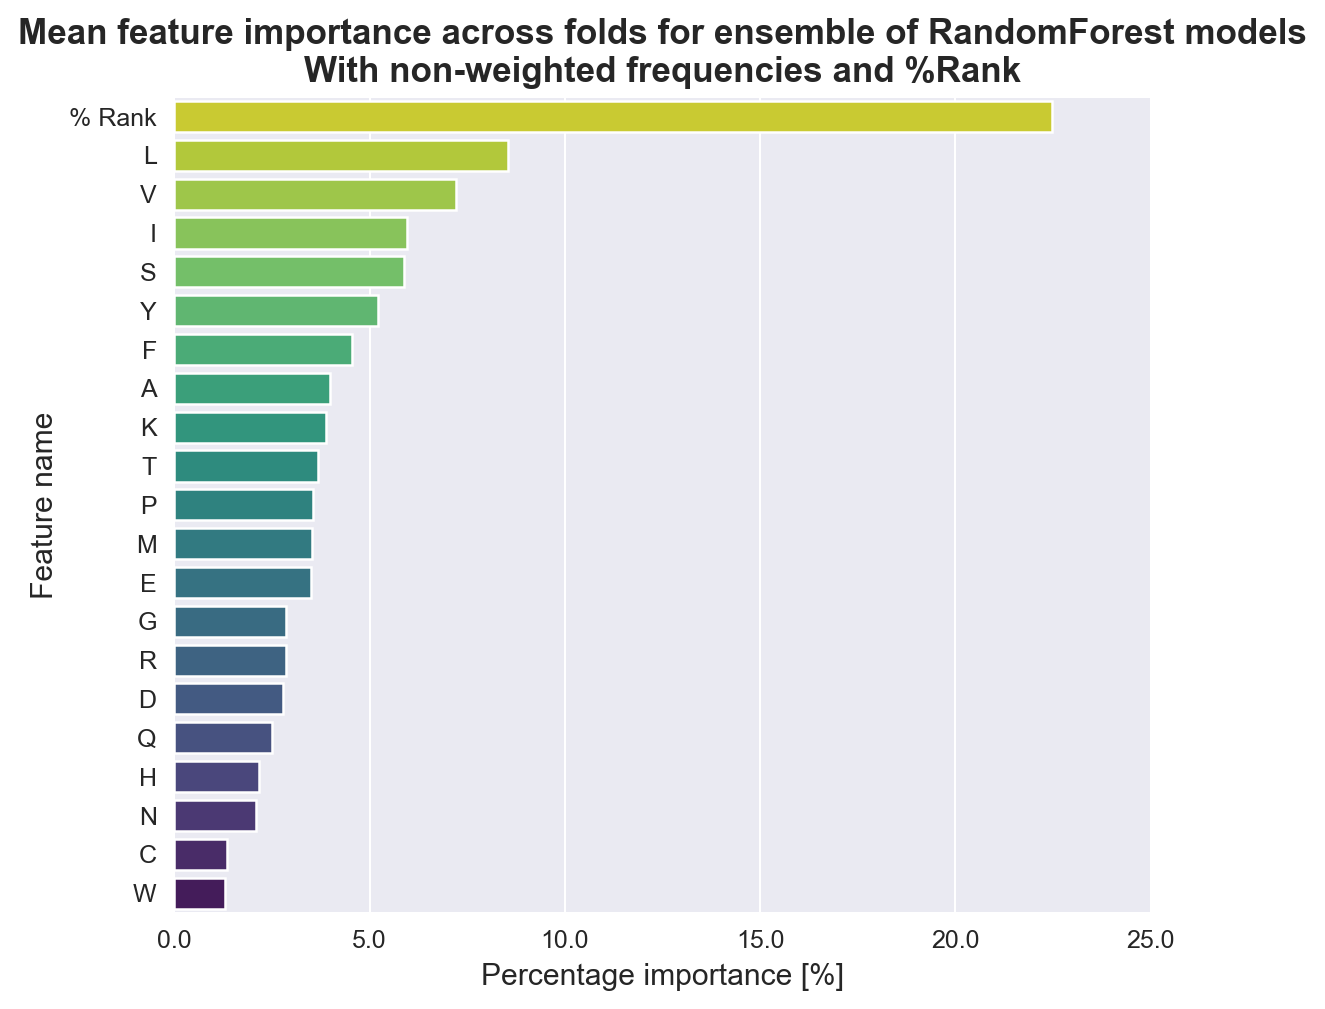

In [619]:
f,a  =plot_feature_importance(mean_feat_imps, AA_KEYS+['% Rank'], 'Mean feature importance across folds for ensemble of RandomForest models\nWith non-weighted frequencies and %Rank')

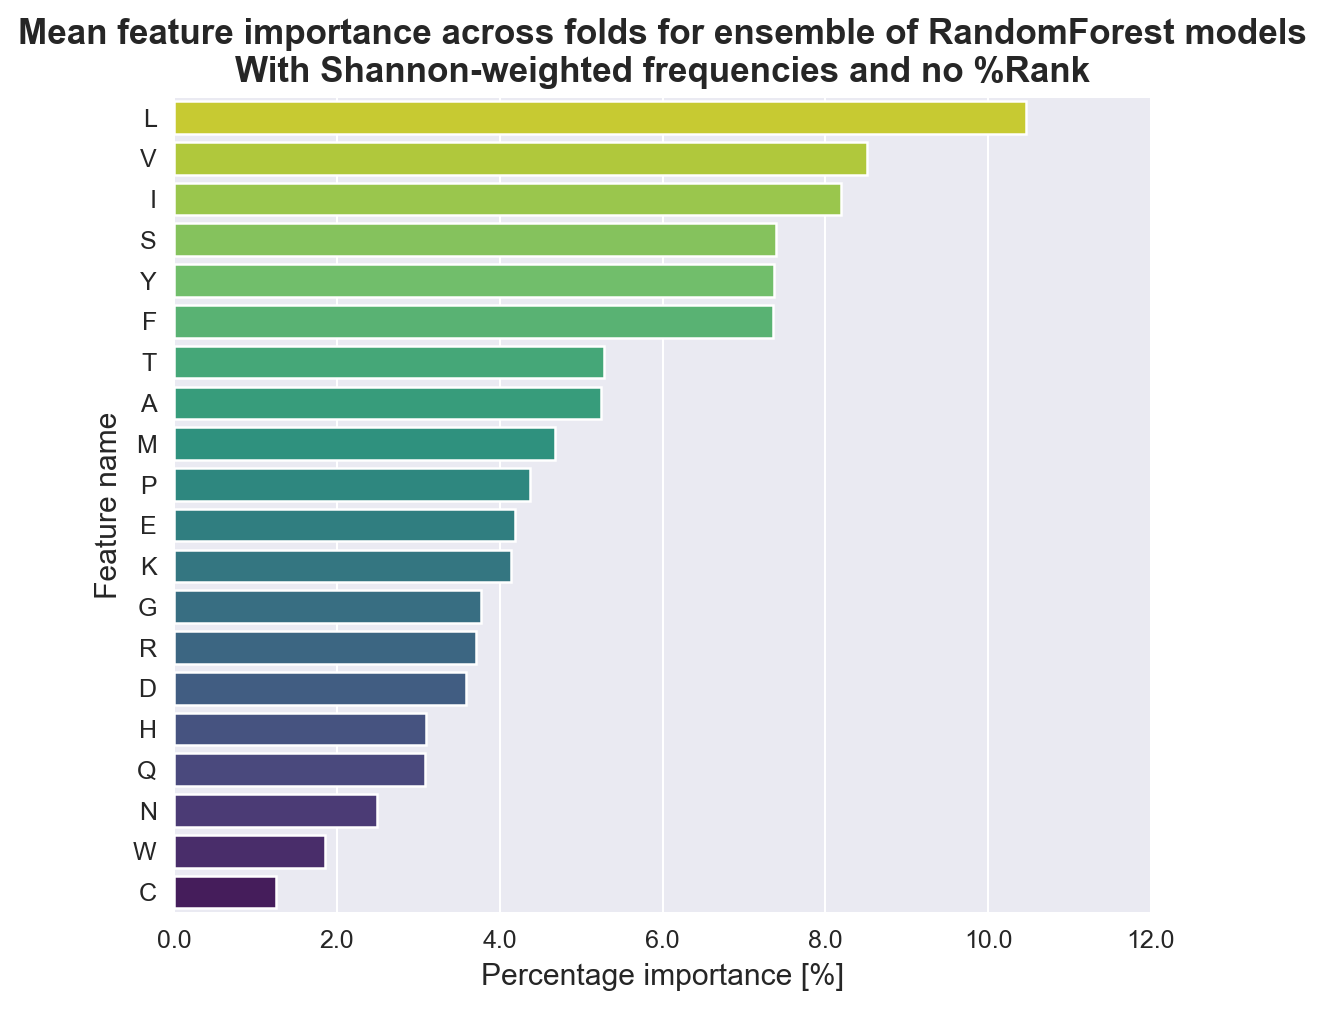

In [620]:
f,a  =plot_feature_importance(mean_feat_imps_norank_shannon, AA_KEYS, 'Mean feature importance across folds for ensemble of RandomForest models\nWith Shannon-weighted frequencies and no %Rank')